<h3>Using the same steps as I did before I will calculate parity with race as sensitive attr<h3>

In [4]:
#Import all of the necessary libraries in
import pandas as pd
import numpy as np
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from folktables import ACSDataSource, ACSIncome
import math
warnings.filterwarnings('ignore')

In [37]:
#This function is being used to calculate the statistical parity of the data set
#test_data: The original data frame containing the test data
#predictors: List of the all the column names AKA IV's
#prediction_df: Contains the predicitons made by the DT model
#sensitive_attr: Name of the sensitive attr
#sensitive_attr_cutoff: Cut off value for sensitive attr
#concat_col: Name of column I am creating new dataframe on

def s_parity(test_data, predictors, prediction_df, sensitive_attr, concat_col):
    #Creating a new DF that contains all the datapoints from the test data and the predictions made from LR model
    #Concat_col: outcome
    test_demo_df = pd.DataFrame(test_data, columns = predictors)
    predicted_df = pd.DataFrame(prediction_df, columns = [concat_col])
    concat_df = pd.concat([test_demo_df,predicted_df], axis=1)

    #Get the two groups of people totals
    total_unpriv = (len(concat_df[concat_df[sensitive_attr]==0]))
    total_priv = (len(concat_df[concat_df[sensitive_attr]==1]))

    #Number of people accepted
    total_credit_unpriv = len(concat_df[(concat_df[concat_col] == 1) & (concat_df[sensitive_attr] == 0)])
    total_credit_priv = len(concat_df[(concat_df[concat_col] == 1) & (concat_df[sensitive_attr] == 1)])

    #Percentage of approved people
    p_unpriv = total_credit_unpriv/total_unpriv
    p_priv = total_credit_priv/total_priv


    #Calculate the parity
    parity = p_priv - p_unpriv


    return parity

In [36]:
#Make changes to make more efficient
#Function used to run the DT model
#train_dataset: Training dataset to train the model
#independent_var: Column names
#dependent_var: Prediction column name
#concat_col: Name of column creating new DF on
def logistic_regression(train_dataset, independent_var, dependent_var, concat_col):
        #Split the data up into train and test values and then run the DT model
        #These steps aren't neccessary to consistenly do over and over again
        x = train_dataset[independent_var].values
        y = train_dataset[dependent_var].values
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=310)
        clf = LogisticRegression(class_weight=None, max_iter=100)
        log = clf.fit(x_train,y_train)
        prediction = log.predict(x_test)

        #Printing the Overall accuracy of the model after one run
        #F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
        #file.write(f'\nAccuracy of the model on Testing Sample Data: {F1_Score}')

        #Prints out the average across all ten run throughs
        #Accuracy_Values=cross_val_score(log, x , y, cv=10, scoring='f1_weighted')

        accuracy = accuracy_score(y_test,prediction)*100

        #After running the model I return a df with the datapoints and the labels
        test_demo_df = pd.DataFrame(x_test, columns = independent_var)
        #Concat_col: credit_risk_12
        predicted_df = pd.DataFrame(prediction, columns = [concat_col])

        return accuracy, test_demo_df, predicted_df

<h4>Connecticut<h4>

In [4]:
#Before conducting analysis I need to access the data and join it together
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
data = data_source.get_data(states=['CT'])
features, labels,_= ACSIncome.df_to_pandas(data)
connecticut_df = pd.concat([features,labels], axis=1)

In [6]:
#After joining them I will code the different columns
#Group the SCHL columns into a single values
#1: Grade School (No Diploman)
#2: High School Diploma/GED
#3: Some College (2 Years at Most)
#4: Bachelor's Degree
#5: Master's Degree
#6: Professional Degree
#7: Doctorate Or Equivalent
ranges = {'GS': (1, 15), 'HSD': (16, 17), 'SC': (18, 20), 'BD': (21,21), 'ME': (22,22), 'PD': (23,23), 'DE': (24,24)}
group_dict = {}

def assign_group(value):
  """Assigns a group label to a value based on the ranges dictionary."""
  if value not in group_dict:
    for group_name, group_range in ranges.items():
      if group_range[0] <= value <= group_range[1]:
        group_dict[value] = group_name
        break
  return group_dict.get(value)

connecticut_df['SCHL'] = connecticut_df['SCHL'].apply(assign_group)

In [7]:
#Assign codes to occupations based on ranges
#0010-0440	11-0000	Management Occupations: 170997
#0500-0960	13-0000	Business and Financial Operations Occupations: 91842
#1005-1240	15-0000	Computer and mathematical occupations: 50817
#1305-1560	17-0000	Architecture and Engineering Occupations: 31718
#1600-1980	19-0000	Life, Physical, and Social Science Occupations: 16529
#2001-2970	21-0000 - 27-0000	Education, Legal, Community Service, Arts, and Media Occupations: 193762
#3000-3550	29-0000	Healthcare Practitioners and Technical Occupations: 100986
#3601-4655	31-0000 - 39-0000	Service Occupations: 283912
#4700-5940	41-0000 - 43-0000	Sales and Office Occupations: 358340
#6005-7640	45-0000 - 49-0000	Natural Resources, Construction, and Maintenance Occupations: 143613
#7700-9760	51-0000 - 53-0000	Production, Transportation, and Material Moving Occupations: 216280
#9800-9920                      Military Specific Occupations: 5704

ranges = {
    'management': (10,440),
    'business': (500,960),
    'computer': (1005,1240),
    'engineering': (1305,1560),
    'life': (1600,1980),
    'education_arts': (2001,2970),
    'healthcare': (3000,3550),
    'service': (3601,4655),
    'sales': (4700,5940),
    'environmental_construction': (6005,7640),
    'production_transportation': (7700,9760),
    'military': (9800,9920)
}
group_dict = {}
connecticut_df['OCCP'] = connecticut_df['OCCP'].apply(assign_group)

In [8]:
#Add family codes 
#1-7: Family
#8-10: inlaws and other family
#11-17: Non-Family
ranges = {
    'family': (0,7),
    'inlaws/other': (8,10),
    'non-family': (11,17)
}
group_dict = {}
connecticut_df['RELP'] = connecticut_df['RELP'].apply(assign_group)

In [9]:
#Code the Class of worker column from numeric to strings
connecticut_df['COW'] = connecticut_df['COW'].replace(1, 'private_business')
connecticut_df['COW'] = connecticut_df['COW'].replace(2, 'non-profit')
connecticut_df['COW'] = connecticut_df['COW'].replace(3, 'local_gov')
connecticut_df['COW'] = connecticut_df['COW'].replace(4, 'state_gov')
connecticut_df['COW'] = connecticut_df['COW'].replace(5, 'federal_gov')
connecticut_df['COW'] = connecticut_df['COW'].replace(6, 'SE_no_business')
connecticut_df['COW'] = connecticut_df['COW'].replace(7, 'SE_business')
connecticut_df['COW'] = connecticut_df['COW'].replace(8, 'no_pay_work')
connecticut_df['COW'] = connecticut_df['COW'].replace(9, 'unemployed')

In [10]:
#Class the Marital Status from numeric to strings
connecticut_df['MAR'] = connecticut_df['MAR'].replace(1, 'married')
connecticut_df['MAR'] = connecticut_df['MAR'].replace(2, 'widowed')
connecticut_df['MAR'] = connecticut_df['MAR'].replace(3, 'divorced')
connecticut_df['MAR'] = connecticut_df['MAR'].replace(4, 'seperated')
connecticut_df['MAR'] = connecticut_df['MAR'].replace(5, 'never_married')

In [11]:
#Add Race codes 
#1-7: Family
#8-10: inlaws and other family
#11-17: Non-Family
ranges = {
    'white': (1,1),
    'non-white': (2,9),
}
group_dict = {}
connecticut_df['RAC1P'] = connecticut_df['RAC1P'].apply(assign_group)

In [13]:
connecticut_df = connecticut_df.drop(columns=['SEX','AGEP'])

In [14]:
encoded_data = pd.get_dummies(connecticut_df, columns=['RELP','COW','SCHL','MAR','OCCP','POBP','RAC1P'])

In [17]:
encoded_data

,WKHP,PINCP,RELP_family,RELP_inlaws/other,RELP_non-family,COW_SE_business,COW_SE_no_business,COW_federal_gov,COW_local_gov,COW_no_pay_work,...,POBP_429.0,POBP_436.0,POBP_440.0,POBP_442.0,POBP_444.0,POBP_457.0,POBP_459.0,POBP_501.0,RAC1P_non-white,RAC1P_white
0,18.0,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,2.0,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,40.0,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,29.0,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,16.0,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,50.0,True,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2996,50.0,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2997,55.0,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2998,55.0,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [15]:
#Get the columns for the predictors and target variable
acs_columns_list = list(encoded_data.columns)

predictors = [item for item in acs_columns_list if item != 'PINCP']
target_var = 'PINCP'

#Setting the columns to each part of the logistic regression
#x conatins the IV's
#y contains the DV
x = encoded_data[predictors].values
y = encoded_data[target_var].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=310)
#X-train is all the data points for training
#y_train contains the labels for each of the training data points
#x_test contains all the testing data points
#y_test contains the ground truth for each of the test data points

#Run the LR classifier
clf = LogisticRegression(class_weight=None, max_iter=100)
lr = clf.fit(x_train,y_train)
prediction = lr.predict(x_test)
prediction_prob = lr.predict_proba(x_train)
accuracy = accuracy_score(y_test,prediction)*100
print(accuracy)


81.16666666666667


In [18]:
#Break the test dataframe into different groups
#Unprotected group is everyone who is a female or 2
#Complement group is everyone who is a male or 1
test_demo_df = pd.DataFrame(x_test, columns = predictors)
predicted_df = pd.DataFrame(prediction, columns = ['income'])
concat_df = pd.concat([test_demo_df,predicted_df], axis=1)

#Get the two groups of people totals
total_unpriv = (len(concat_df[concat_df['RAC1P_white']==0]))
total_priv = (len(concat_df[concat_df['RAC1P_white']==1]))

#Number of people accepted
total_credit_unpriv = len(concat_df[(concat_df['income'] == 1) & (concat_df['RAC1P_white'] == 0)])
total_credit_priv = len(concat_df[(concat_df['income'] == 1) & (concat_df['RAC1P_white'] == 1)])

#Percentage of approved people
p_unpriv = total_credit_unpriv/total_unpriv
p_priv = total_credit_priv/total_priv

statistical_parity = p_priv - p_unpriv
print(f'Statistical Parity: {statistical_parity:.5f}')

Statistical Parity: 0.24767


In [19]:
state_parity = []
state_name = []

state_parity.append(statistical_parity)
state_name.append('CT')

<h5>Iterative Flipping<h5>

In [20]:
#Need to build a new dataframe for training and testing purposes for iterative flipping 
#Combine x_train and y_train
#I combine these so that when I flip the labels I have one DF that I work with
#Rather than 2 numpy.ndarrays
train_demo_df = pd.DataFrame(x_train, columns = predictors)
train_outcome_df = pd.DataFrame(y_train, columns = ['PINCP'])
train_full_df = pd.concat([train_demo_df, train_outcome_df], axis=1)

In [21]:
train_full_df['PINCP'] = train_full_df['PINCP'].replace(True, 1)
train_full_df['PINCP'] = train_full_df['PINCP'].replace(False, 0)

In [22]:
#When flipping the label make sure convert the flip before into its original value

#Combine x_train and y_train
#Retrain the model after combining them and then flip and calculate
#Implement label flipping and recalculate

#Each list holds a different value

#list_parity holds each parity value after each flip and recalculation
list_parity = []
#list_acc holds the accuracy of each iteration after a flip
list_acc = []
#list_flip holds the row number of the flip; starts at 0 and goes through the whole
list_flip = []

#Iterating through the training dataset
for index, row in train_full_df.iterrows():
  #If the row that I am on has the label 1 (credit_risk is the label name) then I will flip it
  #And then run the logistic_regression function to get the accuracy, the DF that contains datapoints,
  #And the DF that contains the predictions
  #The two DF's are then combined in the s_parity function to calculate parity
    if row['PINCP'] == 1:
      #Flip the label
        train_full_df.at[index, 'PINCP'] = 0

        #Run the logistic regression function
        #train_full_df: training dataset
        #predictors: IV's
        #target_var: DV's
        #'credit_risk12': this is the column that the labels for the test_prediction is in
        accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df, predictors, target_var, 'income')

        #list_flip: contains the row number that has just been flipped
        #list_num: contains the accuracy value just calculated
        list_flip.append(index)
        list_acc.append(accuracy)

        ##################################################################################
        #After calculating the accuracy parity calculation is next
        parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
        #list_parity: contains the parity value after the flip
        #print(parity)
        list_parity.append(parity)

        #Flips the label back to its original value
        train_full_df.at[index,'PINCP'] = 1

    #Repeats all the same steps as above but this time if the original label is 2
    elif row['PINCP'] == 0:
        train_full_df.at[index, 'PINCP'] = 1

        accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df, predictors, target_var, 'income')
        list_flip.append(index)
        list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
        #print(parity)
        list_parity.append(parity)

        train_full_df.at[index,'PINCP'] = 0

In [23]:
#parity_difference: Contains the difference between flipped and original value
parity_difference = []
#Contains parity values that fall between .03 and -.03
large_influence = []
#Contains the row number of each flip
li_row = []

#Takes each of the parity values after flipping and compares it to the original parity value
#Appends the difference to a new list
for value in list_parity:
    difference = abs(value) - abs(statistical_parity)
    parity_difference.append(difference)


#Rows are considered to be high influence if they fall in between
for index, item in enumerate(parity_difference):
  if statistical_parity > 0:
    if item <= statistical_parity or item >= -1*(statistical_parity):
        large_influence.append(item)
        li_row.append(index)
  else:
    if item >= statistical_parity or item <= -1*(statistical_parity):
        large_influence.append(item)
        li_row.append(index)

In [24]:
# Combine lists into tuples and zip them
combined_data = list(zip(large_influence, li_row))

# Sort based on statistical parity values in descending order
combined_data.sort(key=lambda x: abs(x[0]), reverse=True)

# Extract sorted indices list and the sorted values
sorted_indices_list = [index for _, index in combined_data]
sorted_values = sorted(large_influence, reverse=True)

In [25]:
#Flip the top 50% of the list
sorted_indices_list = sorted_indices_list[:len(sorted_indices_list)//2]

In [26]:
#After ranking the values it is time to now go back through the flipping process but flip the top 500 labels based on their ranking
#Parity values after each flip
ranked_parity = []
#Accuracy after every flip
ranked_acc = []
#Index/row of the flip
ranked_flip = []

row_num = 0
#sorted_indices is a tuple so it's coverted to a list
ranked_indices_list = list(sorted_indices_list)

#Iterate through the ranked indices and start flipping labels based on their position in the list
for row in range(len(ranked_indices_list)):
  #row_num: contains the row number with respect to the dataframe
  row_num = ranked_indices_list[row]
  #If the label at the specific row is 1 it flips it to 2 then calculates the parity and accuracy
  #It follows the same steps as the flipping before
  if train_full_df.at[row_num,'PINCP'] == 1:
      train_full_df.at[row_num, 'PINCP'] = 0

      accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df, predictors, target_var, 'income')

      ranked_flip.append(row_num)
      ranked_acc.append(accuracy)

      ##################################################################################
      parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
      ranked_parity.append(parity)


  elif train_full_df.at[row_num,'PINCP'] == 0:
      train_full_df.at[row_num, 'PINCP'] = 1

      accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df, predictors, target_var, 'income')

      ranked_flip.append(row_num)
      ranked_acc.append(accuracy)

      ##################################################################################
      parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
      ranked_parity.append(parity)

In [27]:
#Takes the first 150 parity values and their indices and will graph those
top_ranked_parity = ranked_parity[:]
top_ranked_index = ranked_flip[:]

In [28]:
#Place the original parity at the beginning of the list
top_ranked_parity.insert(0,statistical_parity)

<h5>Uncertainty Reduction<h5>

In [29]:
#Create new training dataset
train_demo_df_entropy = pd.DataFrame(x_train, columns = predictors)
train_outcome_df_entropy = pd.DataFrame(y_train, columns = ['PINCP'])
train_full_df_entropy = pd.concat([train_demo_df_entropy, train_outcome_df_entropy], axis=1)

In [30]:
train_full_df_entropy['PINCP'] = train_full_df_entropy['PINCP'].replace(True, 1)
train_full_df_entropy['PINCP'] = train_full_df_entropy['PINCP'].replace(False, 0)

In [31]:
# Obtain predicted probabilities on the training data
predicted_probabilities = lr.predict_proba(x_train)

In [32]:
#Log base two would be: log = math.log(x,2)
#Entropy equation would then be: -1*(p1((math.log(p1,2))+p2*(math.log(p2,2)))

#In the predicted_probabilities: first value is 1 (which is good), second value is 2(which is bad)

#Loop through the predicted_probabilities array and calculate values
#One list will contain the index of each row in the table and the other will contain the entropy value of each row

index_list = []
entropy_list = []

for index, value in enumerate(predicted_probabilities):
  #Calculate p1 and p2
  p1=predicted_probabilities[index,0]
  p2=predicted_probabilities[index,1]
  #Calculate entropy in 3 steps
  entropy_calc1 = p1 * math.log(p1,2)
  entropy_calc2 = p2 * math.log(p2,2)
  entropy_final = -1 * (entropy_calc1 + entropy_calc2)

  #Append the values to their respective lists
  index_list.append(index)
  entropy_list.append(entropy_final)

In [33]:
#Rank the entropy values in decreasing order
#Match the index list with them

#Combine the two lists using zip
combined_list = list(zip(entropy_list, index_list))

#Sort the combined lust based on entropy values in descending order
sorted_list = sorted(combined_list, key = lambda x: x[0], reverse=True)

#Extract the values
sorted_ent_list, sorted_index_list = zip(*sorted_list)

In [34]:
#Convert each of the tuples into lists
ranked_indices_list = list(sorted_index_list)
ranked_entropy_list = list(sorted_ent_list)

#Getting the top 50% values
ranked_indices_list = ranked_indices_list[:len(ranked_indices_list)//2]

In [35]:
#After ranking and getting the top 50% points I flip them based on where they are in the list

#Different lists to hold each of the values
ranked_parity = [statistical_parity]
ranked_acc = []
ranked_flip = []

row_num = 0

#Go through the training dataset and flip the points based on their entropy levels
for row in range(len(ranked_indices_list)):
  row_num = ranked_indices_list[row]

  if train_full_df_entropy.at[row_num,'PINCP'] == 1:
    train_full_df_entropy.at[row_num,'PINCP'] = 0
    accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df_entropy, predictors, target_var, 'income')

    ranked_flip.append(row_num)
    ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white','income')
    ranked_parity.append(parity)

  elif train_full_df_entropy.at[row_num, 'PINCP'] == 0:
    train_full_df_entropy.at[row_num,'PINCP'] = 1
    accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df_entropy, predictors, target_var, 'income')

    ranked_flip.append(row_num)
    ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white','income')
    ranked_parity.append(parity)


<h5>Maximum Expected Utility<h5>

In [36]:
#Create a fresh training dataset
train_demo_df_MEU = pd.DataFrame(x_train, columns = predictors)
train_outcome_df_MEU = pd.DataFrame(y_train, columns = ['PINCP'])
train_full_df_MEU = pd.concat([train_demo_df_MEU, train_outcome_df_MEU], axis=1)

In [37]:
train_full_df_MEU['PINCP'] = train_full_df_MEU['PINCP'].replace(True, 1)
train_full_df_MEU['PINCP'] = train_full_df_MEU['PINCP'].replace(False, 0)

In [38]:
# Obtain predicted probabilities on the training data
predicted_probabilities = lr.predict_proba(x_train)

In [39]:
#Make a copy of the original training dataframe to make changes on
copy_train_full_df = train_full_df_MEU.copy()

In [40]:
#Grab the original label of the DP in the copy dataframe and store in lists along with the index
label = []
row_index = []
for index, row in copy_train_full_df.iterrows():
  label.append(copy_train_full_df.at[index,'PINCP'])
  row_index.append(index)

In [41]:
#Calculate the first part of the MEU equation
MEU_part1_list = []
for index, value in enumerate(label):
  if value == 1:
    prob1 = predicted_probabilities[index,0]
    MEU_part1_calc = prob1 * statistical_parity
    MEU_part1_list.append(MEU_part1_calc)
  elif value == 2:
    prob2 = predicted_probabilities[index,1]
    MEU_part1_calc = prob2 * statistical_parity
    MEU_part1_list.append(MEU_part1_calc)

In [44]:
#Iterate through the copied dataset
#Flip each label and calculate the parity

#When flipping the label make sure convert the flip before into its original value

#Each list holds a different value

#list_parity holds each parity value after each flip and recalculation
MEU_part2_list_parity = []
#list_acc holds the accuracy of each iteration after a flip
MEU_part2_list_acc = []
#list_flip holds the row number of the flip; starts at 0 and goes through the whole
MEU_part2_list_flip = []

#Iterating through the training dataset
for index, row in copy_train_full_df.iterrows():
  #If the row that I am on has the label 1 (credit_risk is the label name) then I will flip it
  #And then run the logistic_regression function to get the accuracy, the DF that contains datapoints,
  #And the DF that contains the predictions
  #The two DF's are then combined in the s_parity function to calculate parity
    if row['PINCP'] == 1:
      #Flip the label
        copy_train_full_df.at[index, 'PINCP'] = 0

        #Run the logistic regression function
        #train_full_df: training dataset
        #predictors: IV's
        #target_var: DV's
        #'credit_risk12': this is the column that the labels for the test_prediction is in
        accuracy,test_datapoints, test_prediction = logistic_regression(copy_train_full_df, predictors, target_var, 'income')

        #list_flip: contains the row number that has just been flipped
        #list_num: contains the accuracy value just calculated
        MEU_part2_list_flip.append(index)
        MEU_part2_list_acc.append(accuracy)

        ##################################################################################
        #After calculating the accuracy parity calculation is next
        parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
        #list_parity: contains the parity value after the flip
        MEU_part2_list_parity.append(parity)

        #Flips the label back to its original value
        copy_train_full_df.at[index,'PINCP'] = 1

    #Repeats all the same steps as above but this time if the original label is 2
    elif row['PINCP'] == 0:
        copy_train_full_df.at[index, 'PINCP'] = 1

        accuracy,test_datapoints, test_prediction = logistic_regression(copy_train_full_df, predictors, target_var, 'income')
        MEU_part2_list_flip.append(index)
        MEU_part2_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white','income')
        MEU_part2_list_parity.append(parity)

        copy_train_full_df.at[index,'PINCP'] = 0

In [45]:
#Second part of the calculation by taking the opposite value
MEU_part2_list = []
for index, value in enumerate(label):
  if value == 1:
    prob1 = predicted_probabilities[index,1]
    MEU_part2_calc = prob1 * MEU_part2_list_parity[index]
    MEU_part2_list.append(MEU_part2_calc)
  elif value == 2:
    prob2 = predicted_probabilities[index,0]
    MEU_part2_calc = prob2 * MEU_part2_list_parity[index]
    MEU_part2_list.append(MEU_part2_calc)

In [46]:
#Add the two lists together
expected_utility_values = []
for part1, part2 in zip(MEU_part1_list, MEU_part2_list):
    expected_utility_values.append(part1 + part2)

In [47]:
#After adding the two lists together I need do the following calculation:
#EU - OG Parity = New ranked value to flip on
new_ranked_value = []

for value in expected_utility_values:
  new_ranked_value.append(value - statistical_parity)

In [48]:
#Flip the lists so that they are in increasing order
#Rank the MEUvalues in Increasing order
#Match the index list with them

#Combine the two lists using zip
combined_list = list(zip(new_ranked_value, row_index))

#Sort the combined lust based on EU values in increasing order
sorted_list = sorted(combined_list, key = lambda x: abs(x[0]), reverse = True)

#Extract the values
sorted_eu_list, sorted_index_list = zip(*sorted_list)

#Get the top 50% of points
sorted_index_list = sorted_index_list[:len(sorted_index_list)//2]

In [50]:
#After ranking and getting the tope 500 points I flip them based on where they are in the list

#Different lists to hold each of the values
MEU_ranked_parity = [statistical_parity]
MEU_ranked_acc = []
MEU_ranked_flip = []

row_num = 0

#Go through the training dataset and flip the points based on their entropy levels
for row in range(len(sorted_index_list)):
  row_num = sorted_index_list[row]

  if train_full_df_MEU.at[row_num,'PINCP'] == 1:
    train_full_df_MEU.at[row_num,'PINCP'] = 0
    accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df_MEU, predictors, target_var, 'income')

    MEU_ranked_flip.append(row_num)
    MEU_ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
    MEU_ranked_parity.append(parity)

  elif train_full_df_MEU.at[row_num, 'PINCP'] == 0:
    train_full_df_MEU.at[row_num,'PINCP'] = 1
    accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df_MEU, predictors, target_var, 'income')

    MEU_ranked_flip.append(row_num)
    MEU_ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
    MEU_ranked_parity.append(parity)




In [51]:
#Convert each of the tuples into lists
ranked_indices_list = list(sorted_index_list)
ranked_eu_list = list(MEU_ranked_parity)

#Get the top 500 points in the list
top_index_points = ranked_indices_list[:500]
top_eu_list = ranked_eu_list[:500]

<h5>Random Flipping<h5>`

In [52]:
#Create a new dataframe with the original data for the random flipping
train_demo_df_random = pd.DataFrame(x_train, columns = predictors)
train_outcome_df_random = pd.DataFrame(y_train, columns = ['PINCP'])
train_full_df_random = pd.concat([train_demo_df_random, train_outcome_df_random], axis=1)

In [53]:
train_full_df_random['PINCP'] = train_full_df_random['PINCP'].replace(True, 1)
train_full_df_random['PINCP'] = train_full_df_random['PINCP'].replace(False, 0)

In [56]:
#Randomized flipping
#Budget of 50
import random

random_list_flip = []
random_list_acc = []
random_list_parity = []

col_name = 'PINCP'
budget = int(len(train_full_df_random)*.2)

#Loops through the budget and will randomly change rows in the dataframe based on the random library
#After changing the row it will calculate the accuracy and parity and then change the value back to its original value
#Follows the same flipping and calculations as before but this time it is with random rows rather than systematic flipping
for iter in range(budget):
    random_row = random.choice(train_full_df_random.index)
    if train_full_df_random.at[random_row,col_name] == 1:
        train_full_df_random.at[random_row,col_name] = 0

        accuracy, test_datapoints, test_prediction = logistic_regression(train_full_df_random, predictors, target_var,'income')

        random_list_flip.append(iter)
        random_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white','income')
        random_list_parity.append(parity)

    elif train_full_df_random.at[random_row,col_name] == 0:
        train_full_df_random.at[random_row,col_name] = 1

        accuracy, test_datapoints, test_prediction = logistic_regression(train_full_df_random, predictors, target_var,'income')
        random_list_flip.append(iter)
        random_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
        random_list_parity.append(parity)

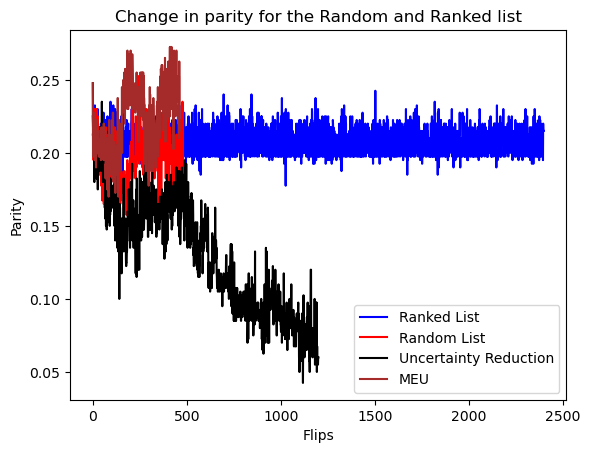

In [57]:
#Plotting the random flips dataset and the systematic flips
#Systematic flips will have 800
#Random will have 150

#Plot the first dataset which is the ranked data list with 800 flips
#list_parity.sort(reverse=True)
x=range(len(list_parity))
plt.plot(x,list_parity,label='Ranked List',color='blue')

#Plot the second dataset which is the random list of 150 flips
x2 = range(len(random_list_parity))
plt.plot(x2,random_list_parity,label='Random List',color='red')

#Entropy based flips
x3 = range(len(ranked_parity))
plt.plot(x3,ranked_parity,label='Uncertainty Reduction',color='black')

#MEU based flips
x4 = range(len(MEU_ranked_parity))
plt.plot(x4,MEU_ranked_parity,label='MEU',color='brown')

#Add the labels
plt.xlabel('Flips')
plt.ylabel('Parity')
plt.title('Change in parity for the Random and Ranked list')

#Add a legend
plt.legend()

#Show the plot
plt.show()

<h4>Wyoming<h4>

In [58]:
#Before conducting analysis I need to access the data and join it together
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
data = data_source.get_data(states=['WY'])
features, labels,_= ACSIncome.df_to_pandas(data)
wyoming_df = pd.concat([features,labels], axis=1)

In [59]:
#After joining them I will code the different columns
#Group the SCHL columns into a single values
#1: Grade School (No Diploman)
#2: High School Diploma/GED
#3: Some College (2 Years at Most)
#4: Bachelor's Degree
#5: Master's Degree
#6: Professional Degree
#7: Doctorate Or Equivalent
ranges = {'GS': (1, 15), 'HSD': (16, 17), 'SC': (18, 20), 'BD': (21,21), 'ME': (22,22), 'PD': (23,23), 'DE': (24,24)}
group_dict = {}

def assign_group(value):
  """Assigns a group label to a value based on the ranges dictionary."""
  if value not in group_dict:
    for group_name, group_range in ranges.items():
      if group_range[0] <= value <= group_range[1]:
        group_dict[value] = group_name
        break
  return group_dict.get(value)

wyoming_df['SCHL'] = wyoming_df['SCHL'].apply(assign_group)

In [60]:
#Assign codes to occupations based on ranges
#0010-0440	11-0000	Management Occupations: 170997
#0500-0960	13-0000	Business and Financial Operations Occupations: 91842
#1005-1240	15-0000	Computer and mathematical occupations: 50817
#1305-1560	17-0000	Architecture and Engineering Occupations: 31718
#1600-1980	19-0000	Life, Physical, and Social Science Occupations: 16529
#2001-2970	21-0000 - 27-0000	Education, Legal, Community Service, Arts, and Media Occupations: 193762
#3000-3550	29-0000	Healthcare Practitioners and Technical Occupations: 100986
#3601-4655	31-0000 - 39-0000	Service Occupations: 283912
#4700-5940	41-0000 - 43-0000	Sales and Office Occupations: 358340
#6005-7640	45-0000 - 49-0000	Natural Resources, Construction, and Maintenance Occupations: 143613
#7700-9760	51-0000 - 53-0000	Production, Transportation, and Material Moving Occupations: 216280
#9800-9920                      Military Specific Occupations: 5704

ranges = {
    'management': (10,440),
    'business': (500,960),
    'computer': (1005,1240),
    'engineering': (1305,1560),
    'life': (1600,1980),
    'education_arts': (2001,2970),
    'healthcare': (3000,3550),
    'service': (3601,4655),
    'sales': (4700,5940),
    'environmental_construction': (6005,7640),
    'production_transportation': (7700,9760),
    'military': (9800,9920)
}
group_dict = {}
wyoming_df['OCCP'] = wyoming_df['OCCP'].apply(assign_group)

In [61]:
#Add family codes 
#1-7: Family
#8-10: inlaws and other family
#11-17: Non-Family
ranges = {
    'family': (0,7),
    'inlaws/other': (8,10),
    'non-family': (11,17)
}
group_dict = {}
wyoming_df['RELP'] = wyoming_df['RELP'].apply(assign_group)

In [62]:
#Code the Class of worker column from numeric to strings
wyoming_df['COW'] = wyoming_df['COW'].replace(1, 'private_business')
wyoming_df['COW'] = wyoming_df['COW'].replace(2, 'non-profit')
wyoming_df['COW'] = wyoming_df['COW'].replace(3, 'local_gov')
wyoming_df['COW'] = wyoming_df['COW'].replace(4, 'state_gov')
wyoming_df['COW'] = wyoming_df['COW'].replace(5, 'federal_gov')
wyoming_df['COW'] = wyoming_df['COW'].replace(6, 'SE_no_business')
wyoming_df['COW'] = wyoming_df['COW'].replace(7, 'SE_business')
wyoming_df['COW'] = wyoming_df['COW'].replace(8, 'no_pay_work')
wyoming_df['COW'] = wyoming_df['COW'].replace(9, 'unemployed')


In [63]:
#Class the Marital Status from numeric to strings
wyoming_df['MAR'] = wyoming_df['MAR'].replace(1, 'married')
wyoming_df['MAR'] = wyoming_df['MAR'].replace(2, 'widowed')
wyoming_df['MAR'] = wyoming_df['MAR'].replace(3, 'divorced')
wyoming_df['MAR'] = wyoming_df['MAR'].replace(4, 'seperated')
wyoming_df['MAR'] = wyoming_df['MAR'].replace(5, 'never_married')

In [65]:
#Add Race codes 
#1-7: Family
#8-10: inlaws and other family
#11-17: Non-Family
ranges = {
    'white': (1,1),
    'non-white': (2,9),
}
group_dict = {}
wyoming_df['RAC1P'] = wyoming_df['RAC1P'].apply(assign_group)

In [66]:
wyoming_df = wyoming_df.drop(columns=['SEX','AGEP'])

In [108]:
encoded_data = pd.get_dummies(wyoming_df, columns=['RELP','COW','SCHL','MAR','OCCP','POBP','RAC1P'])

<h5>Build the Model and get Parity and Accuracy<h5>

In [68]:
#Get the columns for the predictors and target variable
acs_columns_list = list(encoded_data.columns)

predictors = [item for item in acs_columns_list if item != 'PINCP']
target_var = 'PINCP'

#Setting the columns to each part of the logistic regression
#x conatins the IV's
#y contains the DV
x = encoded_data[predictors].values
y = encoded_data[target_var].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=310)
#X-train is all the data points for training
#y_train contains the labels for each of the training data points
#x_test contains all the testing data points
#y_test contains the ground truth for each of the test data points

#Run the LR classifier
clf = LogisticRegression(class_weight=None, max_iter=100)
lr = clf.fit(x_train,y_train)
prediction = lr.predict(x_test)
prediction_prob = lr.predict_proba(x_train)
accuracy = accuracy_score(y_test,prediction)*100
print(accuracy)


78.46655791190864


In [70]:
#Break the test dataframe into different groups
#Unprotected group is everyone who is a female or 2
#Complement group is everyone who is a male or 1
test_demo_df = pd.DataFrame(x_test, columns = predictors)
predicted_df = pd.DataFrame(prediction, columns = ['income'])
concat_df = pd.concat([test_demo_df,predicted_df], axis=1)

#Get the two groups of people totals
total_unpriv = (len(concat_df[concat_df['RAC1P_white']==0]))
total_priv = (len(concat_df[concat_df['RAC1P_white']==1]))

#Number of people accepted
total_credit_unpriv = len(concat_df[(concat_df['income'] == 1) & (concat_df['RAC1P_white'] == 0)])
total_credit_priv = len(concat_df[(concat_df['income'] == 1) & (concat_df['RAC1P_white'] == 1)])

#Percentage of approved people
p_unpriv = total_credit_unpriv/total_unpriv
p_priv = total_credit_priv/total_priv

statistical_parity = p_priv - p_unpriv
print(f'Statistical Parity: {statistical_parity:.5f}')

Statistical Parity: 0.21922


In [71]:
state_parity.append(statistical_parity)
state_name.append('WY')

<h5>Iterative Flipping<h5>

In [72]:
#Need to build a new dataframe for training and testing purposes for iterative flipping 
#Combine x_train and y_train
#I combine these so that when I flip the labels I have one DF that I work with
#Rather than 2 numpy.ndarrays
train_demo_df = pd.DataFrame(x_train, columns = predictors)
train_outcome_df = pd.DataFrame(y_train, columns = ['PINCP'])
train_full_df = pd.concat([train_demo_df, train_outcome_df], axis=1)

In [73]:
train_full_df['PINCP'] = train_full_df['PINCP'].replace(True, 1)
train_full_df['PINCP'] = train_full_df['PINCP'].replace(False, 0)

In [74]:
#When flipping the label make sure convert the flip before into its original value

#Combine x_train and y_train
#Retrain the model after combining them and then flip and calculate
#Implement label flipping and recalculate

#Each list holds a different value

#list_parity holds each parity value after each flip and recalculation
list_parity = []
#list_acc holds the accuracy of each iteration after a flip
list_acc = []
#list_flip holds the row number of the flip; starts at 0 and goes through the whole
list_flip = []

#Iterating through the training dataset
for index, row in train_full_df.iterrows():
  #If the row that I am on has the label 1 (credit_risk is the label name) then I will flip it
  #And then run the logistic_regression function to get the accuracy, the DF that contains datapoints,
  #And the DF that contains the predictions
  #The two DF's are then combined in the s_parity function to calculate parity
    if row['PINCP'] == 1:
      #Flip the label
        train_full_df.at[index, 'PINCP'] = 0

        #Run the logistic regression function
        #train_full_df: training dataset
        #predictors: IV's
        #target_var: DV's
        #'credit_risk12': this is the column that the labels for the test_prediction is in
        accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df, predictors, target_var, 'income')

        #list_flip: contains the row number that has just been flipped
        #list_num: contains the accuracy value just calculated
        list_flip.append(index)
        list_acc.append(accuracy)

        ##################################################################################
        #After calculating the accuracy parity calculation is next
        parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
        #list_parity: contains the parity value after the flip
        #print(parity)
        list_parity.append(parity)

        #Flips the label back to its original value
        train_full_df.at[index,'PINCP'] = 1

    #Repeats all the same steps as above but this time if the original label is 2
    elif row['PINCP'] == 0:
        train_full_df.at[index, 'PINCP'] = 1

        accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df, predictors, target_var, 'income')
        list_flip.append(index)
        list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
        #print(parity)
        list_parity.append(parity)

        train_full_df.at[index,'PINCP'] = 0

In [75]:
#parity_difference: Contains the difference between flipped and original value
parity_difference = []
#Contains parity values that fall between .03 and -.03
large_influence = []
#Contains the row number of each flip
li_row = []

#Takes each of the parity values after flipping and compares it to the original parity value
#Appends the difference to a new list
for value in list_parity:
    difference = abs(value) - abs(statistical_parity)
    parity_difference.append(difference)


#Rows are considered to be high influence if they fall in between
for index, item in enumerate(parity_difference):
  if statistical_parity > 0:
    if item <= statistical_parity or item >= -1*(statistical_parity):
        large_influence.append(item)
        li_row.append(index)
  else:
    if item >= statistical_parity or item <= -1*(statistical_parity):
        large_influence.append(item)
        li_row.append(index)

In [76]:
# Combine lists into tuples and zip them
combined_data = list(zip(large_influence, li_row))

# Sort based on statistical parity values in descending order
combined_data.sort(key=lambda x: abs(x[0]), reverse=True)

# Extract sorted indices list and the sorted values
sorted_indices_list = [index for _, index in combined_data]
sorted_values = sorted(large_influence, reverse=True)

In [77]:
#Get the top 50% of the datapoints
sorted_indices_list = sorted_indices_list[:(len(sorted_indices_list)//2)]

In [78]:
#After ranking the values it is time to now go back through the flipping process but flip the top 500 labels based on their ranking
#Parity values after each flip
ranked_parity = []
#Accuracy after every flip
ranked_acc = []
#Index/row of the flip
ranked_flip = []

row_num = 0
#sorted_indices is a tuple so it's coverted to a list
ranked_indices_list = list(sorted_indices_list)

#Iterate through the ranked indices and start flipping labels based on their position in the list
for row in range(len(ranked_indices_list)):
  #row_num: contains the row number with respect to the dataframe
  row_num = ranked_indices_list[row]
  #If the label at the specific row is 1 it flips it to 2 then calculates the parity and accuracy
  #It follows the same steps as the flipping before
  if train_full_df.at[row_num,'PINCP'] == 1:
      train_full_df.at[row_num, 'PINCP'] = 0

      accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df, predictors, target_var, 'income')

      ranked_flip.append(row_num)
      ranked_acc.append(accuracy)

      ##################################################################################
      parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
      ranked_parity.append(parity)

      #train_full_df.at[index,'credit_risk'] = 1

  elif train_full_df.at[row_num,'PINCP'] == 0:
      train_full_df.at[row_num, 'PINCP'] = 1

      accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df, predictors, target_var, 'income')

      ranked_flip.append(row_num)
      ranked_acc.append(accuracy)

      ##################################################################################
      parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
      ranked_parity.append(parity)

      #train_full_df.at[index,'credit_risk'] = 2




In [79]:
#Takes the first 150 parity values and their indices and will graph those
top_ranked_parity = ranked_parity[:]
top_ranked_index = ranked_flip[:]

In [80]:
#Place the original parity at the beginning of the list
top_ranked_parity.insert(0,statistical_parity)

<h5>Uncertainty Reduction<h5>

In [81]:
#Create new training dataset
train_demo_df_entropy = pd.DataFrame(x_train, columns = predictors)
train_outcome_df_entropy = pd.DataFrame(y_train, columns = ['PINCP'])
train_full_df_entropy = pd.concat([train_demo_df_entropy, train_outcome_df_entropy], axis=1)

In [82]:
train_full_df_entropy['PINCP'] = train_full_df_entropy['PINCP'].replace(True, 1)
train_full_df_entropy['PINCP'] = train_full_df_entropy['PINCP'].replace(False, 0)

In [83]:
# Obtain predicted probabilities on the training data
predicted_probabilities = lr.predict_proba(x_train)

In [84]:
#Log base two would be: log = math.log(x,2)
#Entropy equation would then be: -1*(p1((math.log(p1,2))+p2*(math.log(p2,2)))

#In the predicted_probabilities: first value is 1 (which is good), second value is 2(which is bad)

#Loop through the predicted_probabilities array and calculate values
#One list will contain the index of each row in the table and the other will contain the entropy value of each row

index_list = []
entropy_list = []

for index, value in enumerate(predicted_probabilities):
  #Calculate p1 and p2
  p1=predicted_probabilities[index,0]
  p2=predicted_probabilities[index,1]
  #Calculate entropy in 3 steps
  entropy_calc1 = p1 * math.log(p1,2)
  entropy_calc2 = p2 * math.log(p2,2)
  entropy_final = -1 * (entropy_calc1 + entropy_calc2)

  #Append the values to their respective lists
  index_list.append(index)
  entropy_list.append(entropy_final)

In [85]:
#Rank the entropy values in decreasing order
#Match the index list with them

#Combine the two lists using zip
combined_list = list(zip(entropy_list, index_list))

#Sort the combined lust based on entropy values in descending order
sorted_list = sorted(combined_list, key = lambda x: x[0], reverse=True)

#Extract the values
sorted_ent_list, sorted_index_list = zip(*sorted_list)

In [86]:
#Convert each of the tuples into lists
ranked_indices_list = list(sorted_index_list)
ranked_entropy_list = list(sorted_ent_list)

#Top 50% of the points
ranked_indices_list = ranked_indices_list[:len(ranked_indices_list)//2]

In [87]:
#After ranking and getting the tope 500 points I flip them based on where they are in the list

#Different lists to hold each of the values
ranked_parity = [statistical_parity]
ranked_acc = []
ranked_flip = []

row_num = 0

#Go through the training dataset and flip the points based on their entropy levels
for row in range(len(ranked_indices_list)):
  row_num = ranked_indices_list[row]

  if train_full_df_entropy.at[row_num,'PINCP'] == 1:
    train_full_df_entropy.at[row_num,'PINCP'] = 0
    accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df_entropy, predictors, target_var, 'income')

    ranked_flip.append(row_num)
    ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white','income')
    ranked_parity.append(parity)

  elif train_full_df_entropy.at[row_num, 'PINCP'] == 0:
    train_full_df_entropy.at[row_num,'PINCP'] = 1
    accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df_entropy, predictors, target_var, 'income')

    ranked_flip.append(row_num)
    ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white','income')
    ranked_parity.append(parity)


<h5>Maxium Expected Utility<h5>

In [88]:
#Create a fresh training dataset
train_demo_df_MEU = pd.DataFrame(x_train, columns = predictors)
train_outcome_df_MEU = pd.DataFrame(y_train, columns = ['PINCP'])
train_full_df_MEU = pd.concat([train_demo_df_MEU, train_outcome_df_MEU], axis=1)

In [89]:
train_full_df_MEU['PINCP'] = train_full_df_MEU['PINCP'].replace(True, 1)
train_full_df_MEU['PINCP'] = train_full_df_MEU['PINCP'].replace(False, 0)

In [90]:
# Obtain predicted probabilities on the training data
predicted_probabilities = lr.predict_proba(x_train)

In [91]:
#Make a copy of the original training dataframe to make changes on
copy_train_full_df = train_full_df_MEU.copy()

In [92]:
#Grab the original label of the DP in the copy dataframe and store in lists along with the index
label = []
row_index = []
for index, row in copy_train_full_df.iterrows():
  label.append(copy_train_full_df.at[index,'PINCP'])
  row_index.append(index)

In [93]:
#Calculate the first part of the MEU equation
MEU_part1_list = []
for index, value in enumerate(label):
  if value == 1:
    prob1 = predicted_probabilities[index,0]
    MEU_part1_calc = prob1 * statistical_parity
    MEU_part1_list.append(MEU_part1_calc)
  elif value == 2:
    prob2 = predicted_probabilities[index,1]
    MEU_part1_calc = prob2 * statistical_parity
    MEU_part1_list.append(MEU_part1_calc)

In [95]:
#Iterate through the copied dataset
#Flip each label and calculate the parity

#When flipping the label make sure convert the flip before into its original value

#Each list holds a different value

#list_parity holds each parity value after each flip and recalculation
MEU_part2_list_parity = []
#list_acc holds the accuracy of each iteration after a flip
MEU_part2_list_acc = []
#list_flip holds the row number of the flip; starts at 0 and goes through the whole
MEU_part2_list_flip = []

#Iterating through the training dataset
for index, row in copy_train_full_df.iterrows():
  #If the row that I am on has the label 1 (credit_risk is the label name) then I will flip it
  #And then run the logistic_regression function to get the accuracy, the DF that contains datapoints,
  #And the DF that contains the predictions
  #The two DF's are then combined in the s_parity function to calculate parity
    if row['PINCP'] == 1:
      #Flip the label
        copy_train_full_df.at[index, 'PINCP'] = 0

        #Run the logistic regression function
        #train_full_df: training dataset
        #predictors: IV's
        #target_var: DV's
        #'credit_risk12': this is the column that the labels for the test_prediction is in
        accuracy,test_datapoints, test_prediction = logistic_regression(copy_train_full_df, predictors, target_var, 'income')

        #list_flip: contains the row number that has just been flipped
        #list_num: contains the accuracy value just calculated
        MEU_part2_list_flip.append(index)
        MEU_part2_list_acc.append(accuracy)

        ##################################################################################
        #After calculating the accuracy parity calculation is next
        parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
        #list_parity: contains the parity value after the flip
        MEU_part2_list_parity.append(parity)

        #Flips the label back to its original value
        copy_train_full_df.at[index,'PINCP'] = 1

    #Repeats all the same steps as above but this time if the original label is 2
    elif row['PINCP'] == 0:
        copy_train_full_df.at[index, 'PINCP'] = 1

        accuracy,test_datapoints, test_prediction = logistic_regression(copy_train_full_df, predictors, target_var, 'income')
        MEU_part2_list_flip.append(index)
        MEU_part2_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white','income')
        MEU_part2_list_parity.append(parity)

        copy_train_full_df.at[index,'PINCP'] = 0

In [96]:
#Second part of the calculation by taking the opposite value
MEU_part2_list = []
for index, value in enumerate(label):
  if value == 1:
    prob1 = predicted_probabilities[index,1]
    MEU_part2_calc = prob1 * MEU_part2_list_parity[index]
    MEU_part2_list.append(MEU_part2_calc)
  elif value == 2:
    prob2 = predicted_probabilities[index,0]
    MEU_part2_calc = prob2 * MEU_part2_list_parity[index]
    MEU_part2_list.append(MEU_part2_calc)

In [97]:
#Add the two lists together
expected_utility_values = []
for part1, part2 in zip(MEU_part1_list, MEU_part2_list):
    expected_utility_values.append(part1 + part2)

In [98]:
#After adding the two lists together I need do the following calculation:
#EU - OG Parity = New ranked value to flip on
new_ranked_value = []

for value in expected_utility_values:
  new_ranked_value.append(value - statistical_parity)

In [99]:
#Flip the lists so that they are in increasing order
#Rank the MEUvalues in Increasing order
#Match the index list with them

#Combine the two lists using zip
combined_list = list(zip(new_ranked_value, row_index))

#Sort the combined lust based on EU values in increasing order
sorted_list = sorted(combined_list, key = lambda x: abs(x[0]), reverse = True)

#Extract the values
sorted_eu_list, sorted_index_list = zip(*sorted_list)

In [100]:
#Top 50% of the points
sorted_index_list = sorted_index_list[:len(sorted_index_list)//2]

In [101]:
#After ranking and getting the tope 500 points I flip them based on where they are in the list

#Different lists to hold each of the values
MEU_ranked_parity = [statistical_parity]
MEU_ranked_acc = []
MEU_ranked_flip = []

row_num = 0

#Go through the training dataset and flip the points based on their entropy levels
for row in range(len(sorted_index_list)):
  row_num = sorted_index_list[row]

  if train_full_df_MEU.at[row_num,'PINCP'] == 1:
    train_full_df_MEU.at[row_num,'PINCP'] = 0
    accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df_MEU, predictors, target_var, 'income')

    MEU_ranked_flip.append(row_num)
    MEU_ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
    MEU_ranked_parity.append(parity)

  elif train_full_df_MEU.at[row_num, 'PINCP'] == 0:
    train_full_df_MEU.at[row_num,'PINCP'] = 1
    accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df_MEU, predictors, target_var, 'income')

    MEU_ranked_flip.append(row_num)
    MEU_ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
    MEU_ranked_parity.append(parity)




In [102]:
#Convert each of the tuples into lists
ranked_indices_list = list(sorted_index_list)
ranked_eu_list = list(MEU_ranked_parity)

#Get the top 500 points in the list
top_index_points = ranked_indices_list[:]
top_eu_list = ranked_eu_list[:]

<h5>Random Flipping<h5>`

In [103]:
#Create a new dataframe with the original data for the random flipping
train_demo_df_random = pd.DataFrame(x_train, columns = predictors)
train_outcome_df_random = pd.DataFrame(y_train, columns = ['PINCP'])
train_full_df_random = pd.concat([train_demo_df_random, train_outcome_df_random], axis=1)

In [104]:
train_full_df_random['PINCP'] = train_full_df_random['PINCP'].replace(True, 1)
train_full_df_random['PINCP'] = train_full_df_random['PINCP'].replace(False, 0)

In [106]:
#Randomized flipping
#Budget of 50
import random

random_list_flip = []
random_list_acc = []
random_list_parity = []

col_name = 'PINCP'
budget = int(len(train_full_df_random)*.2)

#Loops through the budget and will randomly change rows in the dataframe based on the random library
#After changing the row it will calculate the accuracy and parity and then change the value back to its original value
#Follows the same flipping and calculations as before but this time it is with random rows rather than systematic flipping
for iter in range(budget):
    random_row = random.choice(train_full_df_random.index)
    if train_full_df_random.at[random_row,col_name] == 1:
        train_full_df_random.at[random_row,col_name] = 0

        accuracy, test_datapoints, test_prediction = logistic_regression(train_full_df_random, predictors, target_var,'income')

        random_list_flip.append(iter)
        random_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white','income')
        random_list_parity.append(parity)

        #train_full_df.at[random_row,col_name] = 1

    elif train_full_df_random.at[random_row,col_name] == 0:
        train_full_df_random.at[random_row,col_name] = 1

        accuracy, test_datapoints, test_prediction = logistic_regression(train_full_df_random, predictors, target_var,'income')
        random_list_flip.append(iter)
        random_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
        random_list_parity.append(parity)

        #train_full_df.at[random_row,col_name] = 2




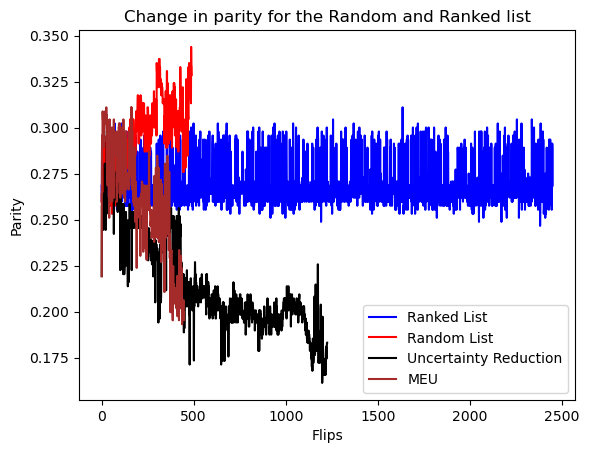

In [107]:
#Plotting the random flips dataset and the systematic flips
#Systematic flips will have 800
#Random will have 150

#Plot the first dataset which is the ranked data list with 800 flips
#list_parity.sort(reverse=True)
x=range(len(list_parity))
plt.plot(x,list_parity,label='Ranked List',color='blue')

#Plot the second dataset which is the random list of 150 flips
x2 = range(len(random_list_parity))
plt.plot(x2,random_list_parity,label='Random List',color='red')

#Entropy based flips
x3 = range(len(ranked_parity))
plt.plot(x3,ranked_parity,label='Uncertainty Reduction',color='black')

#MEU based flips
x4 = range(len(MEU_ranked_parity))
plt.plot(x4,MEU_ranked_parity,label='MEU',color='brown')

#Add the labels
plt.xlabel('Flips')
plt.ylabel('Parity')
plt.title('Change in parity for the Random and Ranked list')

#Add a legend
plt.legend()

#Show the plot
plt.show()

<h5>Arkansas<h5>

In [109]:
#Before conducting analysis I need to access the data and join it together
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
data = data_source.get_data(states=['AK'], download=True)
features, labels,_= ACSIncome.df_to_pandas(data)
arkansas_df = pd.concat([features,labels], axis=1)

In [110]:
#Group the SCHL columns into a single values
#1: Grade School (No Diploman)
#2: High School Diploma/GED
#3: Some College (2 Years at Most)
#4: Bachelor's Degree
#5: Master's Degree
#6: Professional Degree
#7: Doctorate Or Equivalent
ranges = {'GS': (1, 15), 'HSD': (16, 17), 'SC': (18, 20), 'BD': (21,21), 'ME': (22,22), 'PD': (23,23), 'DE': (24,24)}
group_dict = {}

def assign_group(value):
  """Assigns a group label to a value based on the ranges dictionary."""
  if value not in group_dict:
    for group_name, group_range in ranges.items():
      if group_range[0] <= value <= group_range[1]:
        group_dict[value] = group_name
        break
  return group_dict.get(value)

arkansas_df['SCHL'] = arkansas_df['SCHL'].apply(assign_group)

In [111]:
#Assign codes to occupations based on ranges
#0010-0440	11-0000	Management Occupations: 170997
#0500-0960	13-0000	Business and Financial Operations Occupations: 91842
#1005-1240	15-0000	Computer and mathematical occupations: 50817
#1305-1560	17-0000	Architecture and Engineering Occupations: 31718
#1600-1980	19-0000	Life, Physical, and Social Science Occupations: 16529
#2001-2970	21-0000 - 27-0000	Education, Legal, Community Service, Arts, and Media Occupations: 193762
#3000-3550	29-0000	Healthcare Practitioners and Technical Occupations: 100986
#3601-4655	31-0000 - 39-0000	Service Occupations: 283912
#4700-5940	41-0000 - 43-0000	Sales and Office Occupations: 358340
#6005-7640	45-0000 - 49-0000	Natural Resources, Construction, and Maintenance Occupations: 143613
#7700-9760	51-0000 - 53-0000	Production, Transportation, and Material Moving Occupations: 216280
#9800-9920                      Military Specific Occupations: 5704

ranges = {
    'management': (10,440),
    'business': (500,960),
    'computer': (1005,1240),
    'engineering': (1305,1560),
    'life': (1600,1980),
    'education_arts': (2001,2970),
    'healthcare': (3000,3550),
    'service': (3601,4655),
    'sales': (4700,5940),
    'environmental_construction': (6005,7640),
    'production_transportation': (7700,9760),
    'military': (9800,9920)
}
group_dict = {}
arkansas_df['OCCP'] = arkansas_df['OCCP'].apply(assign_group)

In [112]:
#Add family codes 
#1-7: Family
#8-10: inlaws and other family
#11-17: Non-Family
ranges = {
    'family': (0,7),
    'inlaws/other': (8,10),
    'non-family': (11,17)
}
group_dict = {}
arkansas_df['RELP'] = arkansas_df['RELP'].apply(assign_group)

In [113]:
#Code the Class of worker column from numeric to strings
arkansas_df['COW'] = arkansas_df['COW'].replace(1, 'private_business')
arkansas_df['COW'] = arkansas_df['COW'].replace(2, 'non-profit')
arkansas_df['COW'] = arkansas_df['COW'].replace(3, 'local_gov')
arkansas_df['COW'] = arkansas_df['COW'].replace(4, 'state_gov')
arkansas_df['COW'] = arkansas_df['COW'].replace(5, 'federal_gov')
arkansas_df['COW'] = arkansas_df['COW'].replace(6, 'SE_no_business')
arkansas_df['COW'] = arkansas_df['COW'].replace(7, 'SE_business')
arkansas_df['COW'] = arkansas_df['COW'].replace(8, 'no_pay_work')
arkansas_df['COW'] = arkansas_df['COW'].replace(9, 'unemployed')


In [114]:
#Class the Marital Status from numeric to strings
arkansas_df['MAR'] = arkansas_df['MAR'].replace(1, 'married')
arkansas_df['MAR'] = arkansas_df['MAR'].replace(2, 'widowed')
arkansas_df['MAR'] = arkansas_df['MAR'].replace(3, 'divorced')
arkansas_df['MAR'] = arkansas_df['MAR'].replace(4, 'seperated')
arkansas_df['MAR'] = arkansas_df['MAR'].replace(5, 'never_married')

In [116]:
#Add Race codes 
ranges = {
    'white': (1,1),
    'non-white': (2,9),
}
group_dict = {}
arkansas_df['RAC1P'] = arkansas_df['RAC1P'].apply(assign_group)

In [117]:
arkansas_df =arkansas_df.drop(columns=['SEX','AGEP'])

In [118]:
encoded_data = pd.get_dummies(arkansas_df, columns=['RELP','COW','SCHL','MAR','OCCP','POBP','RAC1P'])

<h5>Build the Model and get Parity and Accuracy<h5>

In [119]:
#Get the columns for the predictors and target variable
acs_columns_list = list(encoded_data.columns)

predictors = [item for item in acs_columns_list if item != 'PINCP']
target_var = 'PINCP'

#Setting the columns to each part of the logistic regression
#x conatins the IV's
#y contains the DV
x = encoded_data[predictors].values
y = encoded_data[target_var].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=310)
#X-train is all the data points for training
#y_train contains the labels for each of the training data points
#x_test contains all the testing data points
#y_test contains the ground truth for each of the test data points

#Run the LR classifier
clf = LogisticRegression(class_weight=None, max_iter=100)
lr = clf.fit(x_train,y_train)
prediction = lr.predict(x_test)
prediction_prob = lr.predict_proba(x_train)
accuracy = accuracy_score(y_test,prediction)*100
print(accuracy)


73.80281690140845


In [120]:
#Break the test dataframe into different groups
#Unprotected group is everyone who is a female or 2
#Complement group is everyone who is a male or 1
test_demo_df = pd.DataFrame(x_test, columns = predictors)
predicted_df = pd.DataFrame(prediction, columns = ['income'])
concat_df = pd.concat([test_demo_df,predicted_df], axis=1)

#Get the two groups of people totals
total_unpriv = (len(concat_df[concat_df['RAC1P_white']==0]))
total_priv = (len(concat_df[concat_df['RAC1P_white']==1]))

#Number of people accepted
total_credit_unpriv = len(concat_df[(concat_df['income'] == 1) & (concat_df['RAC1P_white'] == 0)])
total_credit_priv = len(concat_df[(concat_df['income'] == 1) & (concat_df['RAC1P_white'] == 1)])

#Percentage of approved people
p_unpriv = total_credit_unpriv/total_unpriv
p_priv = total_credit_priv/total_priv

statistical_parity = p_priv - p_unpriv
print(f'Statistical Parity: {statistical_parity:.5f}')

Statistical Parity: 0.34003


In [121]:
state_parity.append(statistical_parity)
state_name.append('AK')

<h5>Iterative Flipping<h5>

In [122]:
#Need to build a new dataframe for training and testing purposes for iterative flipping 
#Combine x_train and y_train
#I combine these so that when I flip the labels I have one DF that I work with
#Rather than 2 numpy.ndarrays
train_demo_df = pd.DataFrame(x_train, columns = predictors)
train_outcome_df = pd.DataFrame(y_train, columns = ['PINCP'])
train_full_df = pd.concat([train_demo_df, train_outcome_df], axis=1)

In [123]:
train_full_df['PINCP'] = train_full_df['PINCP'].replace(True, 1)
train_full_df['PINCP'] = train_full_df['PINCP'].replace(False, 0)

In [124]:
#When flipping the label make sure convert the flip before into its original value

#Combine x_train and y_train
#Retrain the model after combining them and then flip and calculate
#Implement label flipping and recalculate

#Each list holds a different value

#list_parity holds each parity value after each flip and recalculation
list_parity = []
#list_acc holds the accuracy of each iteration after a flip
list_acc = []
#list_flip holds the row number of the flip; starts at 0 and goes through the whole
list_flip = []

#Iterating through the training dataset
for index, row in train_full_df.iterrows():
  #If the row that I am on has the label 1 (credit_risk is the label name) then I will flip it
  #And then run the logistic_regression function to get the accuracy, the DF that contains datapoints,
  #And the DF that contains the predictions
  #The two DF's are then combined in the s_parity function to calculate parity
    if row['PINCP'] == 1:
      #Flip the label
        train_full_df.at[index, 'PINCP'] = 0

        #Run the logistic regression function
        #train_full_df: training dataset
        #predictors: IV's
        #target_var: DV's
        #'credit_risk12': this is the column that the labels for the test_prediction is in
        accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df, predictors, target_var, 'income')

        #list_flip: contains the row number that has just been flipped
        #list_num: contains the accuracy value just calculated
        list_flip.append(index)
        list_acc.append(accuracy)

        ##################################################################################
        #After calculating the accuracy parity calculation is next
        parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
        #list_parity: contains the parity value after the flip
        #print(parity)
        list_parity.append(parity)

        #Flips the label back to its original value
        train_full_df.at[index,'PINCP'] = 1

    #Repeats all the same steps as above but this time if the original label is 2
    elif row['PINCP'] == 0:
        train_full_df.at[index, 'PINCP'] = 1

        accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df, predictors, target_var, 'income')
        list_flip.append(index)
        list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
        #print(parity)
        list_parity.append(parity)

        train_full_df.at[index,'PINCP'] = 0

In [125]:
#parity_difference: Contains the difference between flipped and original value
parity_difference = []
#Contains parity values that fall between .03 and -.03
large_influence = []
#Contains the row number of each flip
li_row = []

#Takes each of the parity values after flipping and compares it to the original parity value
#Appends the difference to a new list
for value in list_parity:
    difference = abs(value) - abs(statistical_parity)
    parity_difference.append(difference)


#Rows are considered to be high influence if they fall in between
for index, item in enumerate(parity_difference):
  if statistical_parity > 0:
    if item <= statistical_parity or item >= -1*(statistical_parity):
        large_influence.append(item)
        li_row.append(index)
  else:
    if item >= statistical_parity or item <= -1*(statistical_parity):
        large_influence.append(item)
        li_row.append(index)

In [126]:
# Combine lists into tuples and zip them
combined_data = list(zip(large_influence, li_row))

# Sort based on statistical parity values in descending order
combined_data.sort(key=lambda x: abs(x[0]), reverse=True)

# Extract sorted indices list and the sorted values
sorted_indices_list = [index for _, index in combined_data]
sorted_values = sorted(large_influence, reverse=True)

In [127]:
#50% of the information
sorted_indices_list = sorted_indices_list[:(len(sorted_indices_list)//2)]

In [129]:
#After ranking the values it is time to now go back through the flipping process but flip the top 500 labels based on their ranking
#Parity values after each flip
ranked_parity = []
#Accuracy after every flip
ranked_acc = []
#Index/row of the flip
ranked_flip = []

row_num = 0
#sorted_indices is a tuple so it's coverted to a list
ranked_indices_list = list(sorted_indices_list)

#Iterate through the ranked indices and start flipping labels based on their position in the list
for row in range(len(ranked_indices_list)):
  #row_num: contains the row number with respect to the dataframe
  row_num = ranked_indices_list[row]
  #If the label at the specific row is 1 it flips it to 2 then calculates the parity and accuracy
  #It follows the same steps as the flipping before
  if train_full_df.at[row_num,'PINCP'] == 1:
      train_full_df.at[row_num, 'PINCP'] = 0

      accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df, predictors, target_var, 'income')

      ranked_flip.append(row_num)
      ranked_acc.append(accuracy)

      ##################################################################################
      parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
      ranked_parity.append(parity)

      #train_full_df.at[index,'credit_risk'] = 1

  elif train_full_df.at[row_num,'PINCP'] == 0:
      train_full_df.at[row_num, 'PINCP'] = 1

      accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df, predictors, target_var, 'income')

      ranked_flip.append(row_num)
      ranked_acc.append(accuracy)

      ##################################################################################
      parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
      ranked_parity.append(parity)

      #train_full_df.at[index,'credit_risk'] = 2




In [130]:
#Takes the first 150 parity values and their indices and will graph those
top_ranked_parity = ranked_parity[:]
top_ranked_index = ranked_flip[:]

In [131]:
#Place the original parity at the beginning of the list
top_ranked_parity.insert(0,statistical_parity)

<h5>Uncertainty Reduction<h5>

In [132]:
#Create new training dataset
train_demo_df_entropy = pd.DataFrame(x_train, columns = predictors)
train_outcome_df_entropy = pd.DataFrame(y_train, columns = ['PINCP'])
train_full_df_entropy = pd.concat([train_demo_df_entropy, train_outcome_df_entropy], axis=1)

In [133]:
train_full_df_entropy['PINCP'] = train_full_df_entropy['PINCP'].replace(True, 1)
train_full_df_entropy['PINCP'] = train_full_df_entropy['PINCP'].replace(False, 0)

In [134]:
# Obtain predicted probabilities on the training data
predicted_probabilities = lr.predict_proba(x_train)

In [135]:
#Log base two would be: log = math.log(x,2)
#Entropy equation would then be: -1*(p1((math.log(p1,2))+p2*(math.log(p2,2)))

#In the predicted_probabilities: first value is 1 (which is good), second value is 2(which is bad)

#Loop through the predicted_probabilities array and calculate values
#One list will contain the index of each row in the table and the other will contain the entropy value of each row

index_list = []
entropy_list = []

for index, value in enumerate(predicted_probabilities):
  #Calculate p1 and p2
  p1=predicted_probabilities[index,0]
  p2=predicted_probabilities[index,1]
  #Calculate entropy in 3 steps
  entropy_calc1 = p1 * math.log(p1,2)
  entropy_calc2 = p2 * math.log(p2,2)
  entropy_final = -1 * (entropy_calc1 + entropy_calc2)

  #Append the values to their respective lists
  index_list.append(index)
  entropy_list.append(entropy_final)

In [136]:
#Rank the entropy values in decreasing order
#Match the index list with them

#Combine the two lists using zip
combined_list = list(zip(entropy_list, index_list))

#Sort the combined lust based on entropy values in descending order
sorted_list = sorted(combined_list, key = lambda x: x[0], reverse=True)

#Extract the values
sorted_ent_list, sorted_index_list = zip(*sorted_list)

In [137]:
#Convert each of the tuples into lists
ranked_indices_list = list(sorted_index_list)
ranked_entropy_list = list(sorted_ent_list)

#Top 50% of the points
ranked_indices_list= ranked_indices_list[:(len(ranked_indices_list)//2)]

In [138]:
#After ranking and getting the tope 500 points I flip them based on where they are in the list

#Different lists to hold each of the values
ranked_parity = [statistical_parity]
ranked_acc = []
ranked_flip = []

row_num = 0

#Go through the training dataset and flip the points based on their entropy levels
for row in range(len(ranked_indices_list)):
  row_num = ranked_indices_list[row]

  if train_full_df_entropy.at[row_num,'PINCP'] == 1:
    train_full_df_entropy.at[row_num,'PINCP'] = 0
    accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df_entropy, predictors, target_var, 'income')

    ranked_flip.append(row_num)
    ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white','income')
    ranked_parity.append(parity)

  elif train_full_df_entropy.at[row_num, 'PINCP'] == 0:
    train_full_df_entropy.at[row_num,'PINCP'] = 1
    accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df_entropy, predictors, target_var, 'income')

    ranked_flip.append(row_num)
    ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white','income')
    ranked_parity.append(parity)


<h5>Maximum Expected Utility<h5>

In [139]:
#Create a fresh training dataset
train_demo_df_MEU = pd.DataFrame(x_train, columns = predictors)
train_outcome_df_MEU = pd.DataFrame(y_train, columns = ['PINCP'])
train_full_df_MEU = pd.concat([train_demo_df_MEU, train_outcome_df_MEU], axis=1)

In [140]:
train_full_df_MEU['PINCP'] = train_full_df_MEU['PINCP'].replace(True, 1)
train_full_df_MEU['PINCP'] = train_full_df_MEU['PINCP'].replace(False, 0)

In [141]:
# Obtain predicted probabilities on the training data
predicted_probabilities = lr.predict_proba(x_train)

In [142]:
#Make a copy of the original training dataframe to make changes on
copy_train_full_df = train_full_df_MEU.copy()

In [143]:
#Grab the original label of the DP in the copy dataframe and store in lists along with the index
label = []
row_index = []
for index, row in copy_train_full_df.iterrows():
  label.append(copy_train_full_df.at[index,'PINCP'])
  row_index.append(index)

In [144]:
#Calculate the first part of the MEU equation
MEU_part1_list = []
for index, value in enumerate(label):
  if value == 1:
    prob1 = predicted_probabilities[index,0]
    MEU_part1_calc = prob1 * statistical_parity
    MEU_part1_list.append(MEU_part1_calc)
  elif value == 2:
    prob2 = predicted_probabilities[index,1]
    MEU_part1_calc = prob2 * statistical_parity
    MEU_part1_list.append(MEU_part1_calc)

In [145]:
#Iterate through the copied dataset
#Flip each label and calculate the parity

#When flipping the label make sure convert the flip before into its original value

#Each list holds a different value

#list_parity holds each parity value after each flip and recalculation
MEU_part2_list_parity = []
#list_acc holds the accuracy of each iteration after a flip
MEU_part2_list_acc = []
#list_flip holds the row number of the flip; starts at 0 and goes through the whole
MEU_part2_list_flip = []

#Iterating through the training dataset
for index, row in copy_train_full_df.iterrows():
  #If the row that I am on has the label 1 (credit_risk is the label name) then I will flip it
  #And then run the logistic_regression function to get the accuracy, the DF that contains datapoints,
  #And the DF that contains the predictions
  #The two DF's are then combined in the s_parity function to calculate parity
    if row['PINCP'] == 1:
      #Flip the label
        copy_train_full_df.at[index, 'PINCP'] = 0

        #Run the logistic regression function
        #train_full_df: training dataset
        #predictors: IV's
        #target_var: DV's
        #'credit_risk12': this is the column that the labels for the test_prediction is in
        accuracy,test_datapoints, test_prediction = logistic_regression(copy_train_full_df, predictors, target_var, 'income')

        #list_flip: contains the row number that has just been flipped
        #list_num: contains the accuracy value just calculated
        MEU_part2_list_flip.append(index)
        MEU_part2_list_acc.append(accuracy)

        ##################################################################################
        #After calculating the accuracy parity calculation is next
        parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
        #list_parity: contains the parity value after the flip
        MEU_part2_list_parity.append(parity)

        #Flips the label back to its original value
        copy_train_full_df.at[index,'PINCP'] = 1

    #Repeats all the same steps as above but this time if the original label is 2
    elif row['PINCP'] == 0:
        copy_train_full_df.at[index, 'PINCP'] = 1

        accuracy,test_datapoints, test_prediction = logistic_regression(copy_train_full_df, predictors, target_var, 'income')
        MEU_part2_list_flip.append(index)
        MEU_part2_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white','income')
        MEU_part2_list_parity.append(parity)

        copy_train_full_df.at[index,'PINCP'] = 0

In [146]:
#Second part of the calculation by taking the opposite value
MEU_part2_list = []
for index, value in enumerate(label):
  if value == 1:
    prob1 = predicted_probabilities[index,1]
    MEU_part2_calc = prob1 * MEU_part2_list_parity[index]
    MEU_part2_list.append(MEU_part2_calc)
  elif value == 2:
    prob2 = predicted_probabilities[index,0]
    MEU_part2_calc = prob2 * MEU_part2_list_parity[index]
    MEU_part2_list.append(MEU_part2_calc)

In [147]:
#Add the two lists together
expected_utility_values = []
for part1, part2 in zip(MEU_part1_list, MEU_part2_list):
    expected_utility_values.append(part1 + part2)

In [148]:
#After adding the two lists together I need do the following calculation:
#EU - OG Parity = New ranked value to flip on
new_ranked_value = []

for value in expected_utility_values:
  new_ranked_value.append(value - statistical_parity)

In [149]:
#Flip the lists so that they are in increasing order
#Rank the MEUvalues in Increasing order
#Match the index list with them

#Combine the two lists using zip
combined_list = list(zip(new_ranked_value, row_index))

#Sort the combined lust based on EU values in increasing order
sorted_list = sorted(combined_list, key = lambda x: abs(x[0]), reverse = True)

#Extract the values
sorted_eu_list, sorted_index_list = zip(*sorted_list)

In [150]:
#Getting the top points 
sorted_index_list = sorted_index_list[:(len(sorted_index_list)//2)]

In [151]:
#After ranking and getting the tope 500 points I flip them based on where they are in the list

#Different lists to hold each of the values
MEU_ranked_parity = [statistical_parity]
MEU_ranked_acc = []
MEU_ranked_flip = []

row_num = 0

#Go through the training dataset and flip the points based on their entropy levels
for row in range(len(sorted_index_list)):
  row_num = sorted_index_list[row]

  if train_full_df_MEU.at[row_num,'PINCP'] == 1:
    train_full_df_MEU.at[row_num,'PINCP'] = 0
    accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df_MEU, predictors, target_var, 'income')

    MEU_ranked_flip.append(row_num)
    MEU_ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
    MEU_ranked_parity.append(parity)

  elif train_full_df_MEU.at[row_num, 'PINCP'] == 0:
    train_full_df_MEU.at[row_num,'PINCP'] = 1
    accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df_MEU, predictors, target_var, 'income')

    MEU_ranked_flip.append(row_num)
    MEU_ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
    MEU_ranked_parity.append(parity)




In [152]:
#Convert each of the tuples into lists
ranked_indices_list = list(sorted_index_list)
ranked_eu_list = list(MEU_ranked_parity)

#Get the top 500 points in the list
top_index_points = ranked_indices_list[:500]
top_eu_list = ranked_eu_list[:500]

<h5>Random Flipping<h5>`

In [153]:
#Create a new dataframe with the original data for the random flipping
train_demo_df_random = pd.DataFrame(x_train, columns = predictors)
train_outcome_df_random = pd.DataFrame(y_train, columns = ['PINCP'])
train_full_df_random = pd.concat([train_demo_df_random, train_outcome_df_random], axis=1)

In [154]:
train_full_df_random['PINCP'] = train_full_df_random['PINCP'].replace(True, 1)
train_full_df_random['PINCP'] = train_full_df_random['PINCP'].replace(False, 0)

In [156]:
#Randomized flipping
#Budget of 50
import random

random_list_flip = []
random_list_acc = []
random_list_parity = []

col_name = 'PINCP'
budget = len(train_full_df_random)//2

#Loops through the budget and will randomly change rows in the dataframe based on the random library
#After changing the row it will calculate the accuracy and parity and then change the value back to its original value
#Follows the same flipping and calculations as before but this time it is with random rows rather than systematic flipping
for iter in range(budget):
    random_row = random.choice(train_full_df_random.index)
    if train_full_df_random.at[random_row,col_name] == 1:
        train_full_df_random.at[random_row,col_name] = 0

        accuracy, test_datapoints, test_prediction = logistic_regression(train_full_df_random, predictors, target_var,'income')

        random_list_flip.append(iter)
        random_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white','income')
        random_list_parity.append(parity)

        #train_full_df.at[random_row,col_name] = 1

    elif train_full_df_random.at[random_row,col_name] == 0:
        train_full_df_random.at[random_row,col_name] = 1

        accuracy, test_datapoints, test_prediction = logistic_regression(train_full_df_random, predictors, target_var,'income')
        random_list_flip.append(iter)
        random_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
        random_list_parity.append(parity)

        #train_full_df.at[random_row,col_name] = 2




In [ ]:
#Getting the top 150 accuracy values
top_ranked_acc = ranked_acc[:]
top_ranked_noABS_index = ranked_flip[:]

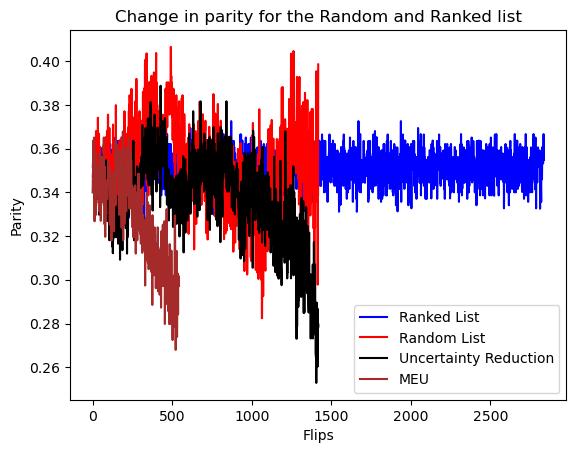

In [157]:
#Plotting the random flips dataset and the systematic flips
#Systematic flips will have 800
#Random will have 150

#Plot the first dataset which is the ranked data list with 800 flips
#list_parity.sort(reverse=True)
x=range(len(list_parity))
plt.plot(x,list_parity,label='Ranked List',color='blue')

#Plot the second dataset which is the random list of 150 flips
x2 = range(len(random_list_parity))
plt.plot(x2,random_list_parity,label='Random List',color='red')

#Entropy based flips
x3 = range(len(ranked_parity))
plt.plot(x3,ranked_parity,label='Uncertainty Reduction',color='black')

#MEU based flips
x4 = range(len(MEU_ranked_parity))
plt.plot(x4,MEU_ranked_parity,label='MEU',color='brown')

#Add the labels
plt.xlabel('Flips')
plt.ylabel('Parity')
plt.title('Change in parity for the Random and Ranked list')

#Add a legend
plt.legend()

#Show the plot
plt.show()

<h5>Vermont<h5>


In [17]:
#Before conducting analysis I need to access the data and join it together
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
data = data_source.get_data(states=['VT'])
features, labels,_= ACSIncome.df_to_pandas(data)
vermont_df = pd.concat([features,labels], axis=1)

In [18]:
#Group the SCHL columns into a single values
#1: Grade School (No Diploman)
#2: High School Diploma/GED
#3: Some College (2 Years at Most)
#4: Bachelor's Degree
#5: Master's Degree
#6: Professional Degree
#7: Doctorate Or Equivalent
ranges = {'GS': (1, 15), 'HSD': (16, 17), 'SC': (18, 20), 'BD': (21,21), 'ME': (22,22), 'PD': (23,23), 'DE': (24,24)}
group_dict = {}

def assign_group(value):
  """Assigns a group label to a value based on the ranges dictionary."""
  if value not in group_dict:
    for group_name, group_range in ranges.items():
      if group_range[0] <= value <= group_range[1]:
        group_dict[value] = group_name
        break
  return group_dict.get(value)

vermont_df['SCHL'] = vermont_df['SCHL'].apply(assign_group)

In [19]:
#Assign codes to occupations based on ranges
#0010-0440	11-0000	Management Occupations: 170997
#0500-0960	13-0000	Business and Financial Operations Occupations: 91842
#1005-1240	15-0000	Computer and mathematical occupations: 50817
#1305-1560	17-0000	Architecture and Engineering Occupations: 31718
#1600-1980	19-0000	Life, Physical, and Social Science Occupations: 16529
#2001-2970	21-0000 - 27-0000	Education, Legal, Community Service, Arts, and Media Occupations: 193762
#3000-3550	29-0000	Healthcare Practitioners and Technical Occupations: 100986
#3601-4655	31-0000 - 39-0000	Service Occupations: 283912
#4700-5940	41-0000 - 43-0000	Sales and Office Occupations: 358340
#6005-7640	45-0000 - 49-0000	Natural Resources, Construction, and Maintenance Occupations: 143613
#7700-9760	51-0000 - 53-0000	Production, Transportation, and Material Moving Occupations: 216280
#9800-9920                      Military Specific Occupations: 5704

ranges = {
    'management': (10,440),
    'business': (500,960),
    'computer': (1005,1240),
    'engineering': (1305,1560),
    'life': (1600,1980),
    'education_arts': (2001,2970),
    'healthcare': (3000,3550),
    'service': (3601,4655),
    'sales': (4700,5940),
    'environmental_construction': (6005,7640),
    'production_transportation': (7700,9760),
    'military': (9800,9920)
}
group_dict = {}
vermont_df['OCCP'] = vermont_df['OCCP'].apply(assign_group)

In [20]:
#Add family codes 
#1-7: Family
#8-10: inlaws and other family
#11-17: Non-Family
ranges = {
    'family': (0,7),
    'inlaws/other': (8,10),
    'non-family': (11,17)
}
group_dict = {}
vermont_df['RELP'] = vermont_df['RELP'].apply(assign_group)

In [21]:
#Code the Class of worker column from numeric to strings
vermont_df['COW'] = vermont_df['COW'].replace(1, 'private_business')
vermont_df['COW'] = vermont_df['COW'].replace(2, 'non-profit')
vermont_df['COW'] = vermont_df['COW'].replace(3, 'local_gov')
vermont_df['COW'] = vermont_df['COW'].replace(4, 'state_gov')
vermont_df['COW'] = vermont_df['COW'].replace(5, 'federal_gov')
vermont_df['COW'] = vermont_df['COW'].replace(6, 'SE_no_business')
vermont_df['COW'] = vermont_df['COW'].replace(7, 'SE_business')
vermont_df['COW'] = vermont_df['COW'].replace(8, 'no_pay_work')
vermont_df['COW'] = vermont_df['COW'].replace(9, 'unemployed')


In [22]:
#Class the Marital Status from numeric to strings
vermont_df['MAR'] = vermont_df['MAR'].replace(1, 'married')
vermont_df['MAR'] = vermont_df['MAR'].replace(2, 'widowed')
vermont_df['MAR'] = vermont_df['MAR'].replace(3, 'divorced')
vermont_df['MAR'] = vermont_df['MAR'].replace(4, 'seperated')
vermont_df['MAR'] = vermont_df['MAR'].replace(5, 'never_married')

In [23]:
#Add Race codes 
ranges = {
    'white': (1,1),
    'non-white': (2,9),
}
group_dict = {}
vermont_df['RAC1P'] = vermont_df['RAC1P'].apply(assign_group)

In [ ]:
vermont_df =vermont_df.drop(columns=['AGEP','SEX'])

In [29]:
encoded_data = pd.get_dummies(vermont_df, columns=['RELP','COW','SCHL','MAR','OCCP','POBP','RAC1P'])

<h5>Build the model and calculate parity<h5>

In [30]:
#Get the columns for the predictors and target variable
acs_columns_list = list(encoded_data.columns)

predictors = [item for item in acs_columns_list if item != 'PINCP']
target_var = 'PINCP'

#Setting the columns to each part of the logistic regression
#x conatins the IV's
#y contains the DV
x = encoded_data[predictors].values
y = encoded_data[target_var].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=310)
#X-train is all the data points for training
#y_train contains the labels for each of the training data points
#x_test contains all the testing data points
#y_test contains the ground truth for each of the test data points

#Run the LR classifier
clf = LogisticRegression(class_weight=None, max_iter=100)
lr = clf.fit(x_train,y_train)
prediction = lr.predict(x_test)
prediction_prob = lr.predict_proba(x_train)
accuracy = accuracy_score(y_test,prediction)*100
print(accuracy)


79.17771883289124


In [31]:
#Break the test dataframe into different groups
#Unprotected group is everyone who is a female or 2
#Complement group is everyone who is a male or 1
test_demo_df = pd.DataFrame(x_test, columns = predictors)
predicted_df = pd.DataFrame(prediction, columns = ['income'])
concat_df = pd.concat([test_demo_df,predicted_df], axis=1)

#Get the two groups of people totals
total_unpriv = (len(concat_df[concat_df['RAC1P_white']==0]))
total_priv = (len(concat_df[concat_df['RAC1P_white']==1]))

#Number of people accepted
total_credit_unpriv = len(concat_df[(concat_df['income'] == 1) & (concat_df['RAC1P_white'] == 0)])
total_credit_priv = len(concat_df[(concat_df['income'] == 1) & (concat_df['RAC1P_white'] == 1)])

#Percentage of approved people
p_unpriv = total_credit_unpriv/total_unpriv
p_priv = total_credit_priv/total_priv

statistical_parity = p_priv - p_unpriv
print(f'Statistical Parity: {statistical_parity:.5f}')

Statistical Parity: 0.16071


In [ ]:
state_parity.append(statistical_parity)
state_name.append('VT')

<h5>Iterative Flipping<h5>

In [33]:
#Need to build a new dataframe for training and testing purposes for iterative flipping 
#Combine x_train and y_train
#I combine these so that when I flip the labels I have one DF that I work with
#Rather than 2 numpy.ndarrays
train_demo_df = pd.DataFrame(x_train, columns = predictors)
train_outcome_df = pd.DataFrame(y_train, columns = ['PINCP'])
train_full_df = pd.concat([train_demo_df, train_outcome_df], axis=1)

In [34]:
train_full_df['PINCP'] = train_full_df['PINCP'].replace(True, 1)
train_full_df['PINCP'] = train_full_df['PINCP'].replace(False, 0)

In [38]:
#When flipping the label make sure convert the flip before into its original value

#Combine x_train and y_train
#Retrain the model after combining them and then flip and calculate
#Implement label flipping and recalculate

#Each list holds a different value

#list_parity holds each parity value after each flip and recalculation
list_parity = []
#list_acc holds the accuracy of each iteration after a flip
list_acc = []
#list_flip holds the row number of the flip; starts at 0 and goes through the whole
list_flip = []

#Iterating through the training dataset
for index, row in train_full_df.iterrows():
  #If the row that I am on has the label 1 (credit_risk is the label name) then I will flip it
  #And then run the logistic_regression function to get the accuracy, the DF that contains datapoints,
  #And the DF that contains the predictions
  #The two DF's are then combined in the s_parity function to calculate parity
    if row['PINCP'] == 1:
      #Flip the label
        train_full_df.at[index, 'PINCP'] = 0

        #Run the logistic regression function
        #train_full_df: training dataset
        #predictors: IV's
        #target_var: DV's
        #'credit_risk12': this is the column that the labels for the test_prediction is in
        accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df, predictors, target_var, 'income')

        #list_flip: contains the row number that has just been flipped
        #list_num: contains the accuracy value just calculated
        list_flip.append(index)
        list_acc.append(accuracy)

        ##################################################################################
        #After calculating the accuracy parity calculation is next
        parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
        #list_parity: contains the parity value after the flip
        #print(parity)
        list_parity.append(parity)

        #Flips the label back to its original value
        train_full_df.at[index,'PINCP'] = 1

    #Repeats all the same steps as above but this time if the original label is 2
    elif row['PINCP'] == 0:
        train_full_df.at[index, 'PINCP'] = 1

        accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df, predictors, target_var, 'income')
        list_flip.append(index)
        list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
        #print(parity)
        list_parity.append(parity)

        train_full_df.at[index,'PINCP'] = 0

In [39]:
#parity_difference: Contains the difference between flipped and original value
parity_difference = []
#Contains parity values that fall between .03 and -.03
large_influence = []
#Contains the row number of each flip
li_row = []

#Takes each of the parity values after flipping and compares it to the original parity value
#Appends the difference to a new list
for value in list_parity:
    difference = abs(value) - abs(statistical_parity)
    parity_difference.append(difference)


#Rows are considered to be high influence if they fall in between
for index, item in enumerate(parity_difference):
  if statistical_parity > 0:
    if item <= statistical_parity or item >= -1*(statistical_parity):
        large_influence.append(item)
        li_row.append(index)
  else:
    if item >= statistical_parity or item <= -1*(statistical_parity):
        large_influence.append(item)
        li_row.append(index)

In [40]:
# Combine lists into tuples and zip them
combined_data = list(zip(large_influence, li_row))

# Sort based on statistical parity values in descending order
combined_data.sort(key=lambda x: abs(x[0]), reverse=True)

# Extract sorted indices list and the sorted values
sorted_indices_list = [index for _, index in combined_data]
sorted_values = sorted(large_influence, reverse=True)

In [41]:
sorted_indices_list = sorted_indices_list[:len(sorted_indices_list)//2]

In [42]:
#After ranking the values it is time to now go back through the flipping process but flip the top 500 labels based on their ranking
#Parity values after each flip
ranked_parity = []
#Accuracy after every flip
ranked_acc = []
#Index/row of the flip
ranked_flip = []

row_num = 0
#sorted_indices is a tuple so it's coverted to a list
ranked_indices_list = list(sorted_indices_list)

#Iterate through the ranked indices and start flipping labels based on their position in the list
for row in range(len(ranked_indices_list)):
  #row_num: contains the row number with respect to the dataframe
  row_num = ranked_indices_list[row]
  #If the label at the specific row is 1 it flips it to 2 then calculates the parity and accuracy
  #It follows the same steps as the flipping before
  if train_full_df.at[row_num,'PINCP'] == 1:
      train_full_df.at[row_num, 'PINCP'] = 0

      accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df, predictors, target_var, 'income')

      ranked_flip.append(row_num)
      ranked_acc.append(accuracy)

      ##################################################################################
      parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
      ranked_parity.append(parity)

      #train_full_df.at[index,'credit_risk'] = 1

  elif train_full_df.at[row_num,'PINCP'] == 0:
      train_full_df.at[row_num, 'PINCP'] = 1

      accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df, predictors, target_var, 'income')

      ranked_flip.append(row_num)
      ranked_acc.append(accuracy)

      ##################################################################################
      parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
      ranked_parity.append(parity)

      #train_full_df.at[index,'credit_risk'] = 2




In [43]:
#Takes the first 150 parity values and their indices and will graph those
top_ranked_parity = ranked_parity[:]
top_ranked_index = ranked_flip[:]

In [44]:
#Place the original parity at the beginning of the list
top_ranked_parity.insert(0,statistical_parity)

<h5>Uncertainty Reduction<h5>

In [45]:
#Create new training dataset
train_demo_df_entropy = pd.DataFrame(x_train, columns = predictors)
train_outcome_df_entropy = pd.DataFrame(y_train, columns = ['PINCP'])
train_full_df_entropy = pd.concat([train_demo_df_entropy, train_outcome_df_entropy], axis=1)

In [46]:
train_full_df_entropy['PINCP'] = train_full_df_entropy['PINCP'].replace(True, 1)
train_full_df_entropy['PINCP'] = train_full_df_entropy['PINCP'].replace(False, 0)

In [47]:
# Obtain predicted probabilities on the training data
predicted_probabilities = lr.predict_proba(x_train)

In [48]:
#Log base two would be: log = math.log(x,2)
#Entropy equation would then be: -1*(p1((math.log(p1,2))+p2*(math.log(p2,2)))

#In the predicted_probabilities: first value is 1 (which is good), second value is 2(which is bad)

#Loop through the predicted_probabilities array and calculate values
#One list will contain the index of each row in the table and the other will contain the entropy value of each row

index_list = []
entropy_list = []

for index, value in enumerate(predicted_probabilities):
  #Calculate p1 and p2
  p1=predicted_probabilities[index,0]
  p2=predicted_probabilities[index,1]
  #Calculate entropy in 3 steps
  entropy_calc1 = p1 * math.log(p1,2)
  entropy_calc2 = p2 * math.log(p2,2)
  entropy_final = -1 * (entropy_calc1 + entropy_calc2)

  #Append the values to their respective lists
  index_list.append(index)
  entropy_list.append(entropy_final)

In [49]:
#Rank the entropy values in decreasing order
#Match the index list with them

#Combine the two lists using zip
combined_list = list(zip(entropy_list, index_list))

#Sort the combined lust based on entropy values in descending order
sorted_list = sorted(combined_list, key = lambda x: x[0], reverse=True)

#Extract the values
sorted_ent_list, sorted_index_list = zip(*sorted_list)

In [50]:
#Convert each of the tuples into lists
ranked_indices_list = list(sorted_index_list)
ranked_entropy_list = list(sorted_ent_list)

ranked_indices_list= ranked_indices_list[:(len(ranked_indices_list)//2)]

In [51]:
#After ranking and getting the tope 500 points I flip them based on where they are in the list

#Different lists to hold each of the values
ranked_parity = [statistical_parity]
ranked_acc = []
ranked_flip = []

row_num = 0

#Go through the training dataset and flip the points based on their entropy levels
for row in range(len(ranked_indices_list)):
  row_num = ranked_indices_list[row]

  if train_full_df_entropy.at[row_num,'PINCP'] == 1:
    train_full_df_entropy.at[row_num,'PINCP'] = 0
    accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df_entropy, predictors, target_var, 'income')

    ranked_flip.append(row_num)
    ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white','income')
    ranked_parity.append(parity)

  elif train_full_df_entropy.at[row_num, 'PINCP'] == 0:
    train_full_df_entropy.at[row_num,'PINCP'] = 1
    accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df_entropy, predictors, target_var, 'income')

    ranked_flip.append(row_num)
    ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white','income')
    ranked_parity.append(parity)


<h5>Maximum Expected Utility<h5>

In [52]:
#Create a fresh training dataset
train_demo_df_MEU = pd.DataFrame(x_train, columns = predictors)
train_outcome_df_MEU = pd.DataFrame(y_train, columns = ['PINCP'])
train_full_df_MEU = pd.concat([train_demo_df_MEU, train_outcome_df_MEU], axis=1)

In [53]:
train_full_df_MEU['PINCP'] = train_full_df_MEU['PINCP'].replace(True, 1)
train_full_df_MEU['PINCP'] = train_full_df_MEU['PINCP'].replace(False, 0)

In [54]:
# Obtain predicted probabilities on the training data
predicted_probabilities = lr.predict_proba(x_train)

In [55]:
#Make a copy of the original training dataframe to make changes on
copy_train_full_df = train_full_df_MEU.copy()

In [56]:
#Grab the original label of the DP in the copy dataframe and store in lists along with the index
label = []
row_index = []
for index, row in copy_train_full_df.iterrows():
  label.append(copy_train_full_df.at[index,'PINCP'])
  row_index.append(index)

In [57]:
#Calculate the first part of the MEU equation
MEU_part1_list = []
for index, value in enumerate(label):
  if value == 1:
    prob1 = predicted_probabilities[index,0]
    MEU_part1_calc = prob1 * statistical_parity
    MEU_part1_list.append(MEU_part1_calc)
  elif value == 2:
    prob2 = predicted_probabilities[index,1]
    MEU_part1_calc = prob2 * statistical_parity
    MEU_part1_list.append(MEU_part1_calc)

In [58]:
#Iterate through the copied dataset
#Flip each label and calculate the parity

#When flipping the label make sure convert the flip before into its original value

#Each list holds a different value

#list_parity holds each parity value after each flip and recalculation
MEU_part2_list_parity = []
#list_acc holds the accuracy of each iteration after a flip
MEU_part2_list_acc = []
#list_flip holds the row number of the flip; starts at 0 and goes through the whole
MEU_part2_list_flip = []

#Iterating through the training dataset
for index, row in copy_train_full_df.iterrows():
  #If the row that I am on has the label 1 (credit_risk is the label name) then I will flip it
  #And then run the logistic_regression function to get the accuracy, the DF that contains datapoints,
  #And the DF that contains the predictions
  #The two DF's are then combined in the s_parity function to calculate parity
    if row['PINCP'] == 1:
      #Flip the label
        copy_train_full_df.at[index, 'PINCP'] = 0

        #Run the logistic regression function
        #train_full_df: training dataset
        #predictors: IV's
        #target_var: DV's
        #'credit_risk12': this is the column that the labels for the test_prediction is in
        accuracy,test_datapoints, test_prediction = logistic_regression(copy_train_full_df, predictors, target_var, 'income')

        #list_flip: contains the row number that has just been flipped
        #list_num: contains the accuracy value just calculated
        MEU_part2_list_flip.append(index)
        MEU_part2_list_acc.append(accuracy)

        ##################################################################################
        #After calculating the accuracy parity calculation is next
        parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
        #list_parity: contains the parity value after the flip
        MEU_part2_list_parity.append(parity)

        #Flips the label back to its original value
        copy_train_full_df.at[index,'PINCP'] = 1

    #Repeats all the same steps as above but this time if the original label is 2
    elif row['PINCP'] == 0:
        copy_train_full_df.at[index, 'PINCP'] = 1

        accuracy,test_datapoints, test_prediction = logistic_regression(copy_train_full_df, predictors, target_var, 'income')
        MEU_part2_list_flip.append(index)
        MEU_part2_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white','income')
        MEU_part2_list_parity.append(parity)

        copy_train_full_df.at[index,'PINCP'] = 0

In [59]:
#Second part of the calculation by taking the opposite value
MEU_part2_list = []
for index, value in enumerate(label):
  if value == 1:
    prob1 = predicted_probabilities[index,1]
    MEU_part2_calc = prob1 * MEU_part2_list_parity[index]
    MEU_part2_list.append(MEU_part2_calc)
  elif value == 2:
    prob2 = predicted_probabilities[index,0]
    MEU_part2_calc = prob2 * MEU_part2_list_parity[index]
    MEU_part2_list.append(MEU_part2_calc)

In [60]:
#Add the two lists together
expected_utility_values = []
for part1, part2 in zip(MEU_part1_list, MEU_part2_list):
    expected_utility_values.append(part1 + part2)

In [61]:
#After adding the two lists together I need do the following calculation:
#EU - OG Parity = New ranked value to flip on
new_ranked_value = []

for value in expected_utility_values:
  new_ranked_value.append(value - statistical_parity)

In [62]:
#Flip the lists so that they are in increasing order
#Rank the MEUvalues in Increasing order
#Match the index list with them

#Combine the two lists using zip
combined_list = list(zip(new_ranked_value, row_index))

#Sort the combined lust based on EU values in increasing order
sorted_list = sorted(combined_list, key = lambda x: abs(x[0]), reverse = True)

#Extract the values
sorted_eu_list, sorted_index_list = zip(*sorted_list)

In [63]:
#Getting the top points 
sorted_index_list = sorted_index_list[:(len(sorted_index_list)//2)]

In [64]:
#After ranking and getting the tope 500 points I flip them based on where they are in the list

#Different lists to hold each of the values
MEU_ranked_parity = [statistical_parity]
MEU_ranked_acc = []
MEU_ranked_flip = []

row_num = 0

#Go through the training dataset and flip the points based on their entropy levels
for row in range(len(sorted_index_list)):
  row_num = sorted_index_list[row]

  if train_full_df_MEU.at[row_num,'PINCP'] == 1:
    train_full_df_MEU.at[row_num,'PINCP'] = 0
    accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df_MEU, predictors, target_var, 'income')

    MEU_ranked_flip.append(row_num)
    MEU_ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
    MEU_ranked_parity.append(parity)

  elif train_full_df_MEU.at[row_num, 'PINCP'] == 0:
    train_full_df_MEU.at[row_num,'PINCP'] = 1
    accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df_MEU, predictors, target_var, 'income')

    MEU_ranked_flip.append(row_num)
    MEU_ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
    MEU_ranked_parity.append(parity)




In [65]:
#Convert each of the tuples into lists
ranked_indices_list = list(sorted_index_list)
ranked_eu_list = list(MEU_ranked_parity)

#Get the top 500 points in the list
top_index_points = ranked_indices_list[:]
top_eu_list = ranked_eu_list[:]

<h5>Random Flipping<h5>`

In [66]:
#Create a new dataframe with the original data for the random flipping
train_demo_df_random = pd.DataFrame(x_train, columns = predictors)
train_outcome_df_random = pd.DataFrame(y_train, columns = ['PINCP'])
train_full_df_random = pd.concat([train_demo_df_random, train_outcome_df_random], axis=1)

In [67]:
train_full_df_random['PINCP'] = train_full_df_random['PINCP'].replace(True, 1)
train_full_df_random['PINCP'] = train_full_df_random['PINCP'].replace(False, 0)

In [68]:
#Randomized flipping
#Budget of 50
import random

random_list_flip = []
random_list_acc = []
random_list_parity = []

col_name = 'PINCP'
budget = int(len(train_full_df_random)*.2)

#Loops through the budget and will randomly change rows in the dataframe based on the random library
#After changing the row it will calculate the accuracy and parity and then change the value back to its original value
#Follows the same flipping and calculations as before but this time it is with random rows rather than systematic flipping
for iter in range(budget):
    random_row = random.choice(train_full_df_random.index)
    if train_full_df_random.at[random_row,col_name] == 1:
        train_full_df_random.at[random_row,col_name] = 0

        accuracy, test_datapoints, test_prediction = logistic_regression(train_full_df_random, predictors, target_var,'income')

        random_list_flip.append(iter)
        random_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white','income')
        random_list_parity.append(parity)

        #train_full_df.at[random_row,col_name] = 1

    elif train_full_df_random.at[random_row,col_name] == 0:
        train_full_df_random.at[random_row,col_name] = 1

        accuracy, test_datapoints, test_prediction = logistic_regression(train_full_df_random, predictors, target_var,'income')
        random_list_flip.append(iter)
        random_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
        random_list_parity.append(parity)

        #train_full_df.at[random_row,col_name] = 2




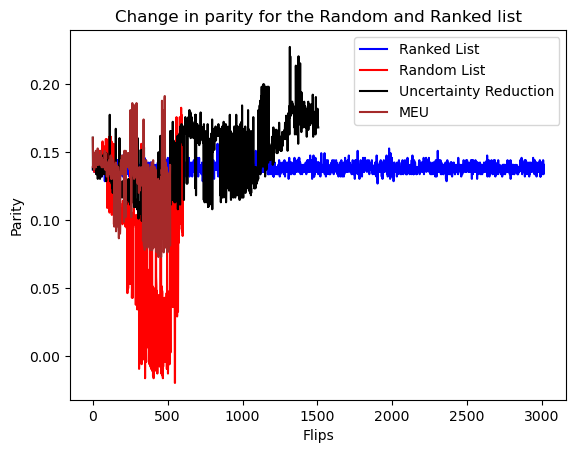

In [70]:
#Plotting the random flips dataset and the systematic flips
#Systematic flips will have 800
#Random will have 150

#Plot the first dataset which is the ranked data list with 800 flips
#list_parity.sort(reverse=True)
x=range(len(list_parity))
plt.plot(x,list_parity,label='Ranked List',color='blue')

#Plot the second dataset which is the random list of 150 flips
x2 = range(len(random_list_parity))
plt.plot(x2,random_list_parity,label='Random List',color='red')

#Entropy based flips
x3 = range(len(ranked_parity))
plt.plot(x3,ranked_parity,label='Uncertainty Reduction',color='black')

#MEU based flips
x4 = range(len(MEU_ranked_parity))
plt.plot(x4,MEU_ranked_parity,label='MEU',color='brown')

#Add the labels
plt.xlabel('Flips')
plt.ylabel('Parity')
plt.title('Change in parity for the Random and Ranked list')

#Add a legend
plt.legend()

#Show the plot
plt.show()

<h5>North Dakota<h5>

In [116]:
#Before conducting analysis I need to access the data and join it together
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
data = data_source.get_data(states=['ND'])
features, labels,_= ACSIncome.df_to_pandas(data)
north_dakota_df = pd.concat([features,labels], axis=1)

In [117]:
#Group the SCHL columns into a single values
#1: Grade School (No Diploman)
#2: High School Diploma/GED
#3: Some College (2 Years at Most)
#4: Bachelor's Degree
#5: Master's Degree
#6: Professional Degree
#7: Doctorate Or Equivalent
ranges = {'GS': (1, 15), 'HSD': (16, 17), 'SC': (18, 20), 'BD': (21,21), 'ME': (22,22), 'PD': (23,23), 'DE': (24,24)}
group_dict = {}

def assign_group(value):
  """Assigns a group label to a value based on the ranges dictionary."""
  if value not in group_dict:
    for group_name, group_range in ranges.items():
      if group_range[0] <= value <= group_range[1]:
        group_dict[value] = group_name
        break
  return group_dict.get(value)

north_dakota_df['SCHL'] = north_dakota_df['SCHL'].apply(assign_group)

In [118]:
#Assign codes to occupations based on ranges
#0010-0440	11-0000	Management Occupations: 170997
#0500-0960	13-0000	Business and Financial Operations Occupations: 91842
#1005-1240	15-0000	Computer and mathematical occupations: 50817
#1305-1560	17-0000	Architecture and Engineering Occupations: 31718
#1600-1980	19-0000	Life, Physical, and Social Science Occupations: 16529
#2001-2970	21-0000 - 27-0000	Education, Legal, Community Service, Arts, and Media Occupations: 193762
#3000-3550	29-0000	Healthcare Practitioners and Technical Occupations: 100986
#3601-4655	31-0000 - 39-0000	Service Occupations: 283912
#4700-5940	41-0000 - 43-0000	Sales and Office Occupations: 358340
#6005-7640	45-0000 - 49-0000	Natural Resources, Construction, and Maintenance Occupations: 143613
#7700-9760	51-0000 - 53-0000	Production, Transportation, and Material Moving Occupations: 216280
#9800-9920                      Military Specific Occupations: 5704

ranges = {
    'management': (10,440),
    'business': (500,960),
    'computer': (1005,1240),
    'engineering': (1305,1560),
    'life': (1600,1980),
    'education_arts': (2001,2970),
    'healthcare': (3000,3550),
    'service': (3601,4655),
    'sales': (4700,5940),
    'environmental_construction': (6005,7640),
    'production_transportation': (7700,9760),
    'military': (9800,9920)
}
group_dict = {}
north_dakota_df['OCCP'] = north_dakota_df['OCCP'].apply(assign_group)

In [119]:
#Add family codes 
#1-7: Family
#8-10: inlaws and other family
#11-17: Non-Family
ranges = {
    'family': (0,7),
    'inlaws/other': (8,10),
    'non-family': (11,17)
}
group_dict = {}
north_dakota_df['RELP'] = north_dakota_df['RELP'].apply(assign_group)

In [120]:
#Code the Class of worker column from numeric to strings
north_dakota_df['COW'] = north_dakota_df['COW'].replace(1, 'private_business')
north_dakota_df['COW'] = north_dakota_df['COW'].replace(2, 'non-profit')
north_dakota_df['COW'] = north_dakota_df['COW'].replace(3, 'local_gov')
north_dakota_df['COW'] = north_dakota_df['COW'].replace(4, 'state_gov')
north_dakota_df['COW'] = north_dakota_df['COW'].replace(5, 'federal_gov')
north_dakota_df['COW'] = north_dakota_df['COW'].replace(6, 'SE_no_business')
north_dakota_df['COW'] = north_dakota_df['COW'].replace(7, 'SE_business')
north_dakota_df['COW'] = north_dakota_df['COW'].replace(8, 'no_pay_work')
north_dakota_df['COW'] = north_dakota_df['COW'].replace(9, 'unemployed')


In [121]:
#Class the Marital Status from numeric to strings
north_dakota_df['MAR'] = north_dakota_df['MAR'].replace(1, 'married')
north_dakota_df['MAR'] = north_dakota_df['MAR'].replace(2, 'widowed')
north_dakota_df['MAR'] = north_dakota_df['MAR'].replace(3, 'divorced')
north_dakota_df['MAR'] = north_dakota_df['MAR'].replace(4, 'seperated')
north_dakota_df['MAR'] = north_dakota_df['MAR'].replace(5, 'never_married')

In [122]:
#Add Race codes 
ranges = {
    'white': (1,1),
    'non-white': (2,9),
}
group_dict = {}
north_dakota_df['RAC1P'] = north_dakota_df['RAC1P'].apply(assign_group)

In [123]:
north_dakota_df =north_dakota_df.drop(columns=['SEX','AGEP'])

In [124]:
encoded_data = pd.get_dummies(north_dakota_df, columns=['RELP','COW','SCHL','MAR','OCCP','POBP','RAC1P'])

<h5>Build Model to get parity and accuracy<h5>

In [125]:
#Get the columns for the predictors and target variable
acs_columns_list = list(encoded_data.columns)

predictors = [item for item in acs_columns_list if item != 'PINCP']
target_var = 'PINCP'

#Setting the columns to each part of the logistic regression
#x conatins the IV's
#y contains the DV
x = encoded_data[predictors].values
y = encoded_data[target_var].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=310)
#X-train is all the data points for training
#y_train contains the labels for each of the training data points
#x_test contains all the testing data points
#y_test contains the ground truth for each of the test data points

#Run the LR classifier
clf = LogisticRegression(class_weight=None, max_iter=100)
lr = clf.fit(x_train,y_train)
prediction = lr.predict(x_test)
prediction_prob = lr.predict_proba(x_train)
accuracy = accuracy_score(y_test,prediction)*100
print(accuracy)


72.16610549943884


In [126]:
#Break the test dataframe into different groups
#Unprotected group is everyone who is a female or 2
#Complement group is everyone who is a male or 1
test_demo_df = pd.DataFrame(x_test, columns = predictors)
predicted_df = pd.DataFrame(prediction, columns = ['income'])
concat_df = pd.concat([test_demo_df,predicted_df], axis=1)

#Get the two groups of people totals
total_unpriv = (len(concat_df[concat_df['RAC1P_white']==0]))
total_priv = (len(concat_df[concat_df['RAC1P_white']==1]))

#Number of people accepted
total_credit_unpriv = len(concat_df[(concat_df['income'] == 1) & (concat_df['RAC1P_white'] == 0)])
total_credit_priv = len(concat_df[(concat_df['income'] == 1) & (concat_df['RAC1P_white'] == 1)])

#Percentage of approved people
p_unpriv = total_credit_unpriv/total_unpriv
p_priv = total_credit_priv/total_priv

statistical_parity = p_priv - p_unpriv
print(f'Statistical Parity: {statistical_parity:.5f}')

Statistical Parity: 0.15522


In [127]:
state_parity.append(statistical_parity)
state_name.append('ND')

NameError: name 'state_parity' is not defined

<h5>Iterative Flipping<h5>

In [128]:
#Need to build a new dataframe for training and testing purposes for iterative flipping 
#Combine x_train and y_train
#I combine these so that when I flip the labels I have one DF that I work with
#Rather than 2 numpy.ndarrays
train_demo_df = pd.DataFrame(x_train, columns = predictors)
train_outcome_df = pd.DataFrame(y_train, columns = ['PINCP'])
train_full_df = pd.concat([train_demo_df, train_outcome_df], axis=1)

In [129]:
train_full_df['PINCP'] = train_full_df['PINCP'].replace(True, 1)
train_full_df['PINCP'] = train_full_df['PINCP'].replace(False, 0)

In [130]:
#When flipping the label make sure convert the flip before into its original value

#Combine x_train and y_train
#Retrain the model after combining them and then flip and calculate
#Implement label flipping and recalculate

#Each list holds a different value

#list_parity holds each parity value after each flip and recalculation
list_parity = []
#list_acc holds the accuracy of each iteration after a flip
list_acc = []
#list_flip holds the row number of the flip; starts at 0 and goes through the whole
list_flip = []

#Iterating through the training dataset
for index, row in train_full_df.iterrows():
  #If the row that I am on has the label 1 (credit_risk is the label name) then I will flip it
  #And then run the logistic_regression function to get the accuracy, the DF that contains datapoints,
  #And the DF that contains the predictions
  #The two DF's are then combined in the s_parity function to calculate parity
    if row['PINCP'] == 1:
      #Flip the label
        train_full_df.at[index, 'PINCP'] = 0

        #Run the logistic regression function
        #train_full_df: training dataset
        #predictors: IV's
        #target_var: DV's
        #'credit_risk12': this is the column that the labels for the test_prediction is in
        accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df, predictors, target_var, 'income')

        #list_flip: contains the row number that has just been flipped
        #list_num: contains the accuracy value just calculated
        list_flip.append(index)
        list_acc.append(accuracy)

        ##################################################################################
        #After calculating the accuracy parity calculation is next
        parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
        #list_parity: contains the parity value after the flip
        #print(parity)
        list_parity.append(parity)

        #Flips the label back to its original value
        train_full_df.at[index,'PINCP'] = 1

    #Repeats all the same steps as above but this time if the original label is 2
    elif row['PINCP'] == 0:
        train_full_df.at[index, 'PINCP'] = 1

        accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df, predictors, target_var, 'income')
        list_flip.append(index)
        list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
        #print(parity)
        list_parity.append(parity)

        train_full_df.at[index,'PINCP'] = 0

In [131]:
#parity_difference: Contains the difference between flipped and original value
parity_difference = []
#Contains parity values that fall between .03 and -.03
large_influence = []
#Contains the row number of each flip
li_row = []

#Takes each of the parity values after flipping and compares it to the original parity value
#Appends the difference to a new list
for value in list_parity:
    difference = abs(value) - abs(statistical_parity)
    parity_difference.append(difference)


#Rows are considered to be high influence if they fall in between
for index, item in enumerate(parity_difference):
  if statistical_parity > 0:
    if item <= statistical_parity or item >= -1*(statistical_parity):
        large_influence.append(item)
        li_row.append(index)
  else:
    if item >= statistical_parity or item <= -1*(statistical_parity):
        large_influence.append(item)
        li_row.append(index)

In [132]:
# Combine lists into tuples and zip them
combined_data = list(zip(large_influence, li_row))

# Sort based on statistical parity values in descending order
combined_data.sort(key=lambda x: abs(x[0]), reverse=True)

# Extract sorted indices list and the sorted values
sorted_indices_list = [index for _, index in combined_data]
sorted_values = sorted(large_influence, reverse=True)

In [133]:
sorted_indices_list = sorted_indices_list[:len(sorted_indices_list)//2]

In [134]:
#After ranking the values it is time to now go back through the flipping process but flip the top 500 labels based on their ranking
#Parity values after each flip
ranked_parity = []
#Accuracy after every flip
ranked_acc = []
#Index/row of the flip
ranked_flip = []

row_num = 0
#sorted_indices is a tuple so it's coverted to a list
ranked_indices_list = list(sorted_indices_list)

#Iterate through the ranked indices and start flipping labels based on their position in the list
for row in range(len(ranked_indices_list)):
  #row_num: contains the row number with respect to the dataframe
  row_num = ranked_indices_list[row]
  #If the label at the specific row is 1 it flips it to 2 then calculates the parity and accuracy
  #It follows the same steps as the flipping before
  if train_full_df.at[row_num,'PINCP'] == 1:
      train_full_df.at[row_num, 'PINCP'] = 0

      accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df, predictors, target_var, 'income')

      ranked_flip.append(row_num)
      ranked_acc.append(accuracy)

      ##################################################################################
      parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
      ranked_parity.append(parity)

      #train_full_df.at[index,'credit_risk'] = 1

  elif train_full_df.at[row_num,'PINCP'] == 0:
      train_full_df.at[row_num, 'PINCP'] = 1

      accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df, predictors, target_var, 'income')

      ranked_flip.append(row_num)
      ranked_acc.append(accuracy)

      ##################################################################################
      parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
      ranked_parity.append(parity)

      #train_full_df.at[index,'credit_risk'] = 2




In [135]:
#Takes the first 150 parity values and their indices and will graph those
top_ranked_parity = ranked_parity[:]
top_ranked_index = ranked_flip[:]

In [136]:
#Place the original parity at the beginning of the list
top_ranked_parity.insert(0,statistical_parity)

<h5>Uncertainty Reduction<h5>

In [137]:
#Create new training dataset
train_demo_df_entropy = pd.DataFrame(x_train, columns = predictors)
train_outcome_df_entropy = pd.DataFrame(y_train, columns = ['PINCP'])
train_full_df_entropy = pd.concat([train_demo_df_entropy, train_outcome_df_entropy], axis=1)

In [138]:
train_full_df_entropy['PINCP'] = train_full_df_entropy['PINCP'].replace(True, 1)
train_full_df_entropy['PINCP'] = train_full_df_entropy['PINCP'].replace(False, 0)

In [139]:
# Obtain predicted probabilities on the training data
predicted_probabilities = lr.predict_proba(x_train)

In [140]:
#Log base two would be: log = math.log(x,2)
#Entropy equation would then be: -1*(p1((math.log(p1,2))+p2*(math.log(p2,2)))

#In the predicted_probabilities: first value is 1 (which is good), second value is 2(which is bad)

#Loop through the predicted_probabilities array and calculate values
#One list will contain the index of each row in the table and the other will contain the entropy value of each row

index_list = []
entropy_list = []

for index, value in enumerate(predicted_probabilities):
  #Calculate p1 and p2
  p1=predicted_probabilities[index,0]
  p2=predicted_probabilities[index,1]
  #Calculate entropy in 3 steps
  entropy_calc1 = p1 * math.log(p1,2)
  entropy_calc2 = p2 * math.log(p2,2)
  entropy_final = -1 * (entropy_calc1 + entropy_calc2)

  #Append the values to their respective lists
  index_list.append(index)
  entropy_list.append(entropy_final)

In [141]:
#Rank the entropy values in decreasing order
#Match the index list with them

#Combine the two lists using zip
combined_list = list(zip(entropy_list, index_list))

#Sort the combined lust based on entropy values in descending order
sorted_list = sorted(combined_list, key = lambda x: x[0], reverse=True)

#Extract the values
sorted_ent_list, sorted_index_list = zip(*sorted_list)

In [142]:
#Convert each of the tuples into lists
ranked_indices_list = list(sorted_index_list)
ranked_entropy_list = list(sorted_ent_list)

ranked_indices_list= ranked_indices_list[:(len(ranked_indices_list)//2)]

In [143]:
#After ranking and getting the tope 500 points I flip them based on where they are in the list

#Different lists to hold each of the values
ranked_parity = [statistical_parity]
ranked_acc = []
ranked_flip = []

row_num = 0

#Go through the training dataset and flip the points based on their entropy levels
for row in range(len(ranked_indices_list)):
  row_num = ranked_indices_list[row]

  if train_full_df_entropy.at[row_num,'PINCP'] == 1:
    train_full_df_entropy.at[row_num,'PINCP'] = 0
    accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df_entropy, predictors, target_var, 'income')

    ranked_flip.append(row_num)
    ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white','income')
    ranked_parity.append(parity)

  elif train_full_df_entropy.at[row_num, 'PINCP'] == 0:
    train_full_df_entropy.at[row_num,'PINCP'] = 1
    accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df_entropy, predictors, target_var, 'income')

    ranked_flip.append(row_num)
    ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white','income')
    ranked_parity.append(parity)


<h5>Maximum Expected Utility<h5>

In [144]:
#Create a fresh training dataset
train_demo_df_MEU = pd.DataFrame(x_train, columns = predictors)
train_outcome_df_MEU = pd.DataFrame(y_train, columns = ['PINCP'])
train_full_df_MEU = pd.concat([train_demo_df_MEU, train_outcome_df_MEU], axis=1)

In [145]:
train_full_df_MEU['PINCP'] = train_full_df_MEU['PINCP'].replace(True, 1)
train_full_df_MEU['PINCP'] = train_full_df_MEU['PINCP'].replace(False, 0)

In [146]:
# Obtain predicted probabilities on the training data
predicted_probabilities = lr.predict_proba(x_train)

In [147]:
#Make a copy of the original training dataframe to make changes on
copy_train_full_df = train_full_df_MEU.copy()

In [148]:
#Grab the original label of the DP in the copy dataframe and store in lists along with the index
label = []
row_index = []
for index, row in copy_train_full_df.iterrows():
  label.append(copy_train_full_df.at[index,'PINCP'])
  row_index.append(index)

In [149]:
#Calculate the first part of the MEU equation
MEU_part1_list = []
for index, value in enumerate(label):
  if value == 1:
    prob1 = predicted_probabilities[index,0]
    MEU_part1_calc = prob1 * statistical_parity
    MEU_part1_list.append(MEU_part1_calc)
  elif value == 2:
    prob2 = predicted_probabilities[index,1]
    MEU_part1_calc = prob2 * statistical_parity
    MEU_part1_list.append(MEU_part1_calc)

In [150]:
#Iterate through the copied dataset
#Flip each label and calculate the parity

#When flipping the label make sure convert the flip before into its original value

#Each list holds a different value

#list_parity holds each parity value after each flip and recalculation
MEU_part2_list_parity = []
#list_acc holds the accuracy of each iteration after a flip
MEU_part2_list_acc = []
#list_flip holds the row number of the flip; starts at 0 and goes through the whole
MEU_part2_list_flip = []

#Iterating through the training dataset
for index, row in copy_train_full_df.iterrows():
  #If the row that I am on has the label 1 (credit_risk is the label name) then I will flip it
  #And then run the logistic_regression function to get the accuracy, the DF that contains datapoints,
  #And the DF that contains the predictions
  #The two DF's are then combined in the s_parity function to calculate parity
    if row['PINCP'] == 1:
      #Flip the label
        copy_train_full_df.at[index, 'PINCP'] = 0

        #Run the logistic regression function
        #train_full_df: training dataset
        #predictors: IV's
        #target_var: DV's
        #'credit_risk12': this is the column that the labels for the test_prediction is in
        accuracy,test_datapoints, test_prediction = logistic_regression(copy_train_full_df, predictors, target_var, 'income')

        #list_flip: contains the row number that has just been flipped
        #list_num: contains the accuracy value just calculated
        MEU_part2_list_flip.append(index)
        MEU_part2_list_acc.append(accuracy)

        ##################################################################################
        #After calculating the accuracy parity calculation is next
        parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
        #list_parity: contains the parity value after the flip
        MEU_part2_list_parity.append(parity)

        #Flips the label back to its original value
        copy_train_full_df.at[index,'PINCP'] = 1

    #Repeats all the same steps as above but this time if the original label is 2
    elif row['PINCP'] == 0:
        copy_train_full_df.at[index, 'PINCP'] = 1

        accuracy,test_datapoints, test_prediction = logistic_regression(copy_train_full_df, predictors, target_var, 'income')
        MEU_part2_list_flip.append(index)
        MEU_part2_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white','income')
        MEU_part2_list_parity.append(parity)

        copy_train_full_df.at[index,'PINCP'] = 0

In [151]:
#Second part of the calculation by taking the opposite value
MEU_part2_list = []
for index, value in enumerate(label):
  if value == 1:
    prob1 = predicted_probabilities[index,1]
    MEU_part2_calc = prob1 * MEU_part2_list_parity[index]
    MEU_part2_list.append(MEU_part2_calc)
  elif value == 2:
    prob2 = predicted_probabilities[index,0]
    MEU_part2_calc = prob2 * MEU_part2_list_parity[index]
    MEU_part2_list.append(MEU_part2_calc)

In [152]:
#Add the two lists together
expected_utility_values = []
for part1, part2 in zip(MEU_part1_list, MEU_part2_list):
    expected_utility_values.append(part1 + part2)

In [153]:
#After adding the two lists together I need do the following calculation:
#EU - OG Parity = New ranked value to flip on
new_ranked_value = []

for value in expected_utility_values:
  new_ranked_value.append(value - statistical_parity)

In [154]:
#Flip the lists so that they are in increasing order
#Rank the MEUvalues in Increasing order
#Match the index list with them

#Combine the two lists using zip
combined_list = list(zip(new_ranked_value, row_index))

#Sort the combined lust based on EU values in increasing order
sorted_list = sorted(combined_list, key = lambda x: abs(x[0]), reverse = True)

#Extract the values
sorted_eu_list, sorted_index_list = zip(*sorted_list)

In [155]:
#Getting the top points 
sorted_index_list = sorted_index_list[:(len(sorted_index_list)//2)]

In [156]:
#After ranking and getting the tope 500 points I flip them based on where they are in the list

#Different lists to hold each of the values
MEU_ranked_parity = [statistical_parity]
MEU_ranked_acc = []
MEU_ranked_flip = []

row_num = 0

#Go through the training dataset and flip the points based on their entropy levels
for row in range(len(sorted_index_list)):
  row_num = sorted_index_list[row]

  if train_full_df_MEU.at[row_num,'PINCP'] == 1:
    train_full_df_MEU.at[row_num,'PINCP'] = 0
    accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df_MEU, predictors, target_var, 'income')

    MEU_ranked_flip.append(row_num)
    MEU_ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
    MEU_ranked_parity.append(parity)

  elif train_full_df_MEU.at[row_num, 'PINCP'] == 0:
    train_full_df_MEU.at[row_num,'PINCP'] = 1
    accuracy,test_datapoints, test_prediction = logistic_regression(train_full_df_MEU, predictors, target_var, 'income')

    MEU_ranked_flip.append(row_num)
    MEU_ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
    MEU_ranked_parity.append(parity)




In [157]:
#Convert each of the tuples into lists
ranked_indices_list = list(sorted_index_list)
ranked_eu_list = list(MEU_ranked_parity)

#Get the top 500 points in the list
top_index_points = ranked_indices_list[:]
top_eu_list = ranked_eu_list[:]

<h5>Random Flipping<h5>`

In [158]:
#Create a new dataframe with the original data for the random flipping
train_demo_df_random = pd.DataFrame(x_train, columns = predictors)
train_outcome_df_random = pd.DataFrame(y_train, columns = ['PINCP'])
train_full_df_random = pd.concat([train_demo_df_random, train_outcome_df_random], axis=1)

In [159]:
train_full_df_random['PINCP'] = train_full_df_random['PINCP'].replace(True, 1)
train_full_df_random['PINCP'] = train_full_df_random['PINCP'].replace(False, 0)

In [160]:
#Randomized flipping
#Budget of 50
import random

random_list_flip = []
random_list_acc = []
random_list_parity = []

col_name = 'PINCP'
budget = int(len(train_full_df_random)*.2)

#Loops through the budget and will randomly change rows in the dataframe based on the random library
#After changing the row it will calculate the accuracy and parity and then change the value back to its original value
#Follows the same flipping and calculations as before but this time it is with random rows rather than systematic flipping
for iter in range(budget):
    random_row = random.choice(train_full_df_random.index)
    if train_full_df_random.at[random_row,col_name] == 1:
        train_full_df_random.at[random_row,col_name] = 0

        accuracy, test_datapoints, test_prediction = logistic_regression(train_full_df_random, predictors, target_var,'income')

        random_list_flip.append(iter)
        random_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white','income')
        random_list_parity.append(parity)

        #train_full_df.at[random_row,col_name] = 1

    elif train_full_df_random.at[random_row,col_name] == 0:
        train_full_df_random.at[random_row,col_name] = 1

        accuracy, test_datapoints, test_prediction = logistic_regression(train_full_df_random, predictors, target_var,'income')
        random_list_flip.append(iter)
        random_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'RAC1P_white', 'income')
        random_list_parity.append(parity)

        #train_full_df.at[random_row,col_name] = 2




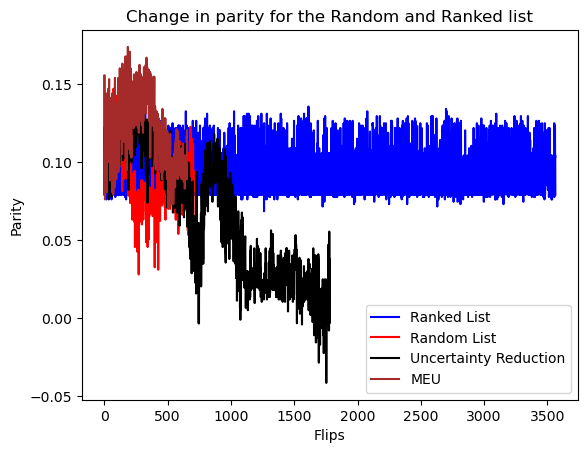

In [161]:
#Plotting the random flips dataset and the systematic flips
#Systematic flips will have 800
#Random will have 150

#Plot the first dataset which is the ranked data list with 800 flips
#list_parity.sort(reverse=True)
x=range(len(list_parity))
plt.plot(x,list_parity,label='Ranked List',color='blue')

#Plot the second dataset which is the random list of 150 flips
x2 = range(len(random_list_parity))
plt.plot(x2,random_list_parity,label='Random List',color='red')

#Entropy based flips
x3 = range(len(ranked_parity))
plt.plot(x3,ranked_parity,label='Uncertainty Reduction',color='black')

#MEU based flips
x4 = range(len(MEU_ranked_parity))
plt.plot(x4,MEU_ranked_parity,label='MEU',color='brown')

#Add the labels
plt.xlabel('Flips')
plt.ylabel('Parity')
plt.title('Change in parity for the Random and Ranked list')

#Add a legend
plt.legend()

#Show the plot
plt.show()